In [11]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [12]:
import os
import pandas as pd

# Initialize lists to store image paths and labels
images = []
labels = []

srcdir = 'Downloads/ALZHEIMERS_MINI_PROJECT'  # Make sure this path is correct

for subfolder in os.listdir(srcdir):
    subfolder_path = os.path.join(srcdir, subfolder)
    if os.path.isdir(subfolder_path):  # Ensure it's a directory
        for folder in os.listdir(subfolder_path):
            folder_path = os.path.join(subfolder_path, folder)
            if os.path.isdir(folder_path):  # Ensure it's a directory
                for image_filename in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, image_filename)
                    images.append(image_path)
                    labels.append(folder)

# Create a DataFrame
df = pd.DataFrame({'image': images, 'label': labels})

print(df.head())  # Print the first few rows to check


                                               image             label
0  Downloads/ALZHEIMERS_MINI_PROJECT/Datasets/Ver...  VeryMildDemented
1  Downloads/ALZHEIMERS_MINI_PROJECT/Datasets/Ver...  VeryMildDemented
2  Downloads/ALZHEIMERS_MINI_PROJECT/Datasets/Ver...  VeryMildDemented
3  Downloads/ALZHEIMERS_MINI_PROJECT/Datasets/Ver...  VeryMildDemented
4  Downloads/ALZHEIMERS_MINI_PROJECT/Datasets/Ver...  VeryMildDemented


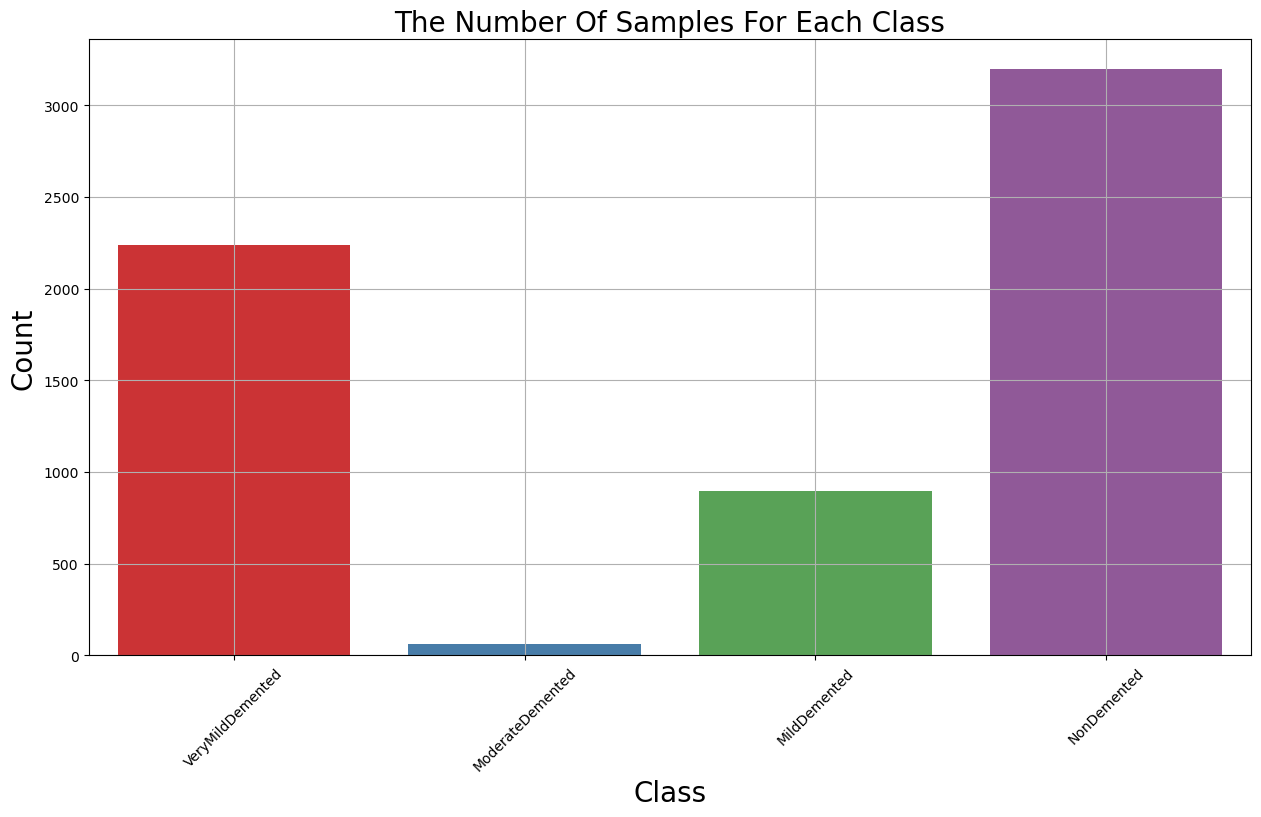

In [13]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

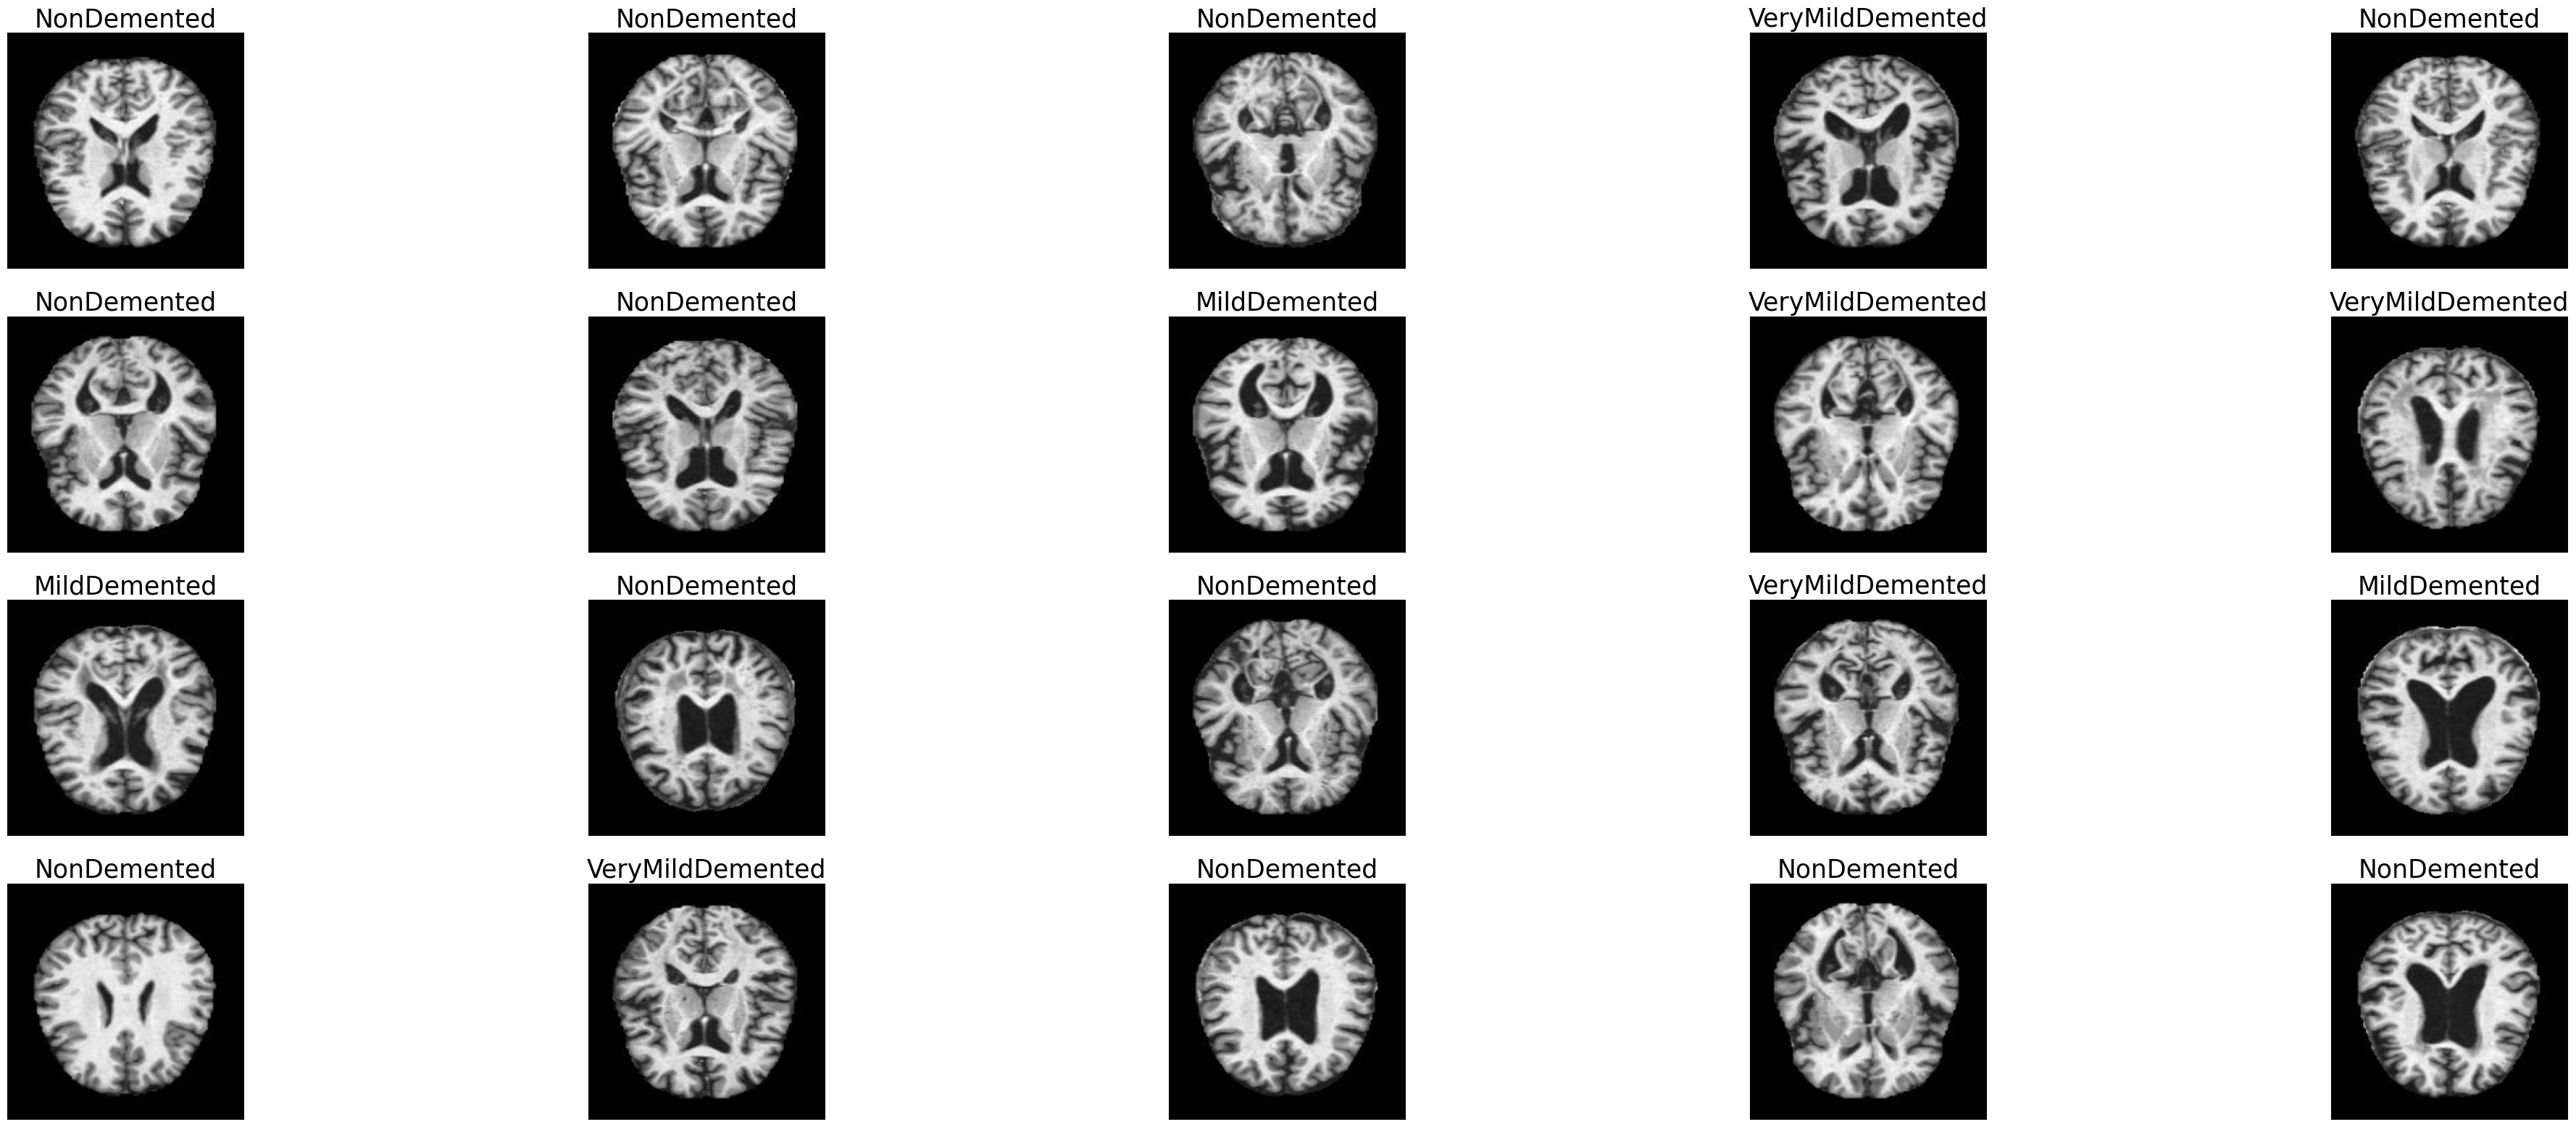

In [17]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [19]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [21]:
train_data, train_labels = next(train_data_gen)


In [22]:
class_num=list(train_data_gen.class_indices.keys())
class_num

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [25]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)


(12800, 176, 176, 3) (12800, 4)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


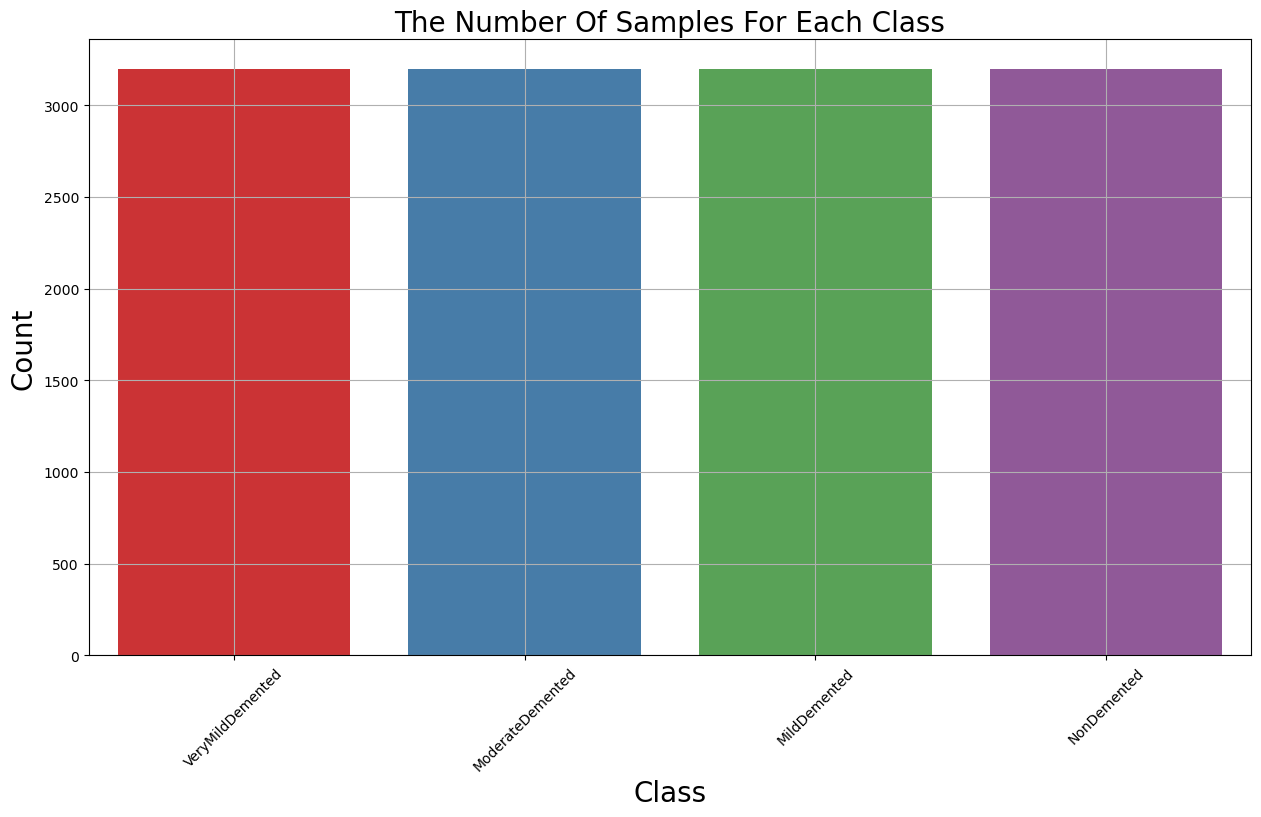

In [26]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [27]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


CUSTOM CNN MODEL

In [14]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(176,176,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(4,activation='softmax'))
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 88, 88, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,180,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,278,020 (4.88 MB)

 Trainable params: 1,278,020 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
checkpoint_cb =ModelCheckpoint("CNN_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=30, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.4174 - loss: 1.1435 - val_accuracy: 0.7464 - val_loss: 0.5479
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.7767 - loss: 0.4962 - val_accuracy: 0.8276 - val_loss: 0.3596
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8750 - loss: 0.2962 - val_accuracy: 0.8833 - val_loss: 0.2717
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9324 - loss: 0.1713 - val_accuracy: 0.9208 - val_loss: 0.1917
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9616 - loss: 0.0972 - val_accuracy: 0.9568 - val_loss: 0.1226
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9691 - loss: 0.0817 - val_accuracy: 0.9661 - val_loss: 0.1147
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9797 - loss: 0.0590 - val_accuracy: 0.9641 - val_loss: 0.1009
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9860 - loss: 0.0338 - 

In [16]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0   0.563951  0.884839      0.746354  0.547892
1   0.799665  0.440003      0.827604  0.359595
2   0.884152  0.272579      0.883333  0.271661
3   0.936384  0.161418      0.920833  0.191658
4   0.961496  0.098364      0.956771  0.122615
5   0.973996  0.067628      0.966146  0.114719
6   0.979353  0.058106      0.964063  0.100944
7   0.985491  0.036004      0.967708  0.087977
8   0.985045  0.037445      0.961458  0.099721
9   0.989397  0.029164      0.973437  0.069173
10  0.989955  0.028221      0.969792  0.078450
11  0.992076  0.022574      0.978646  0.062791
12  0.993304  0.019363      0.978125  0.061318
13  0.987054  0.037591      0.980729  0.060254
14  0.989286  0.031082      0.967188  0.082324
15  0.995982  0.011155      0.985937  0.043654
16  0.986049  0.039890      0.982292  0.049189
17  0.994643  0.014699      0.982813  0.069819
18  0.989174  0.029656      0.968750  0.107968
19  0.995201  0.015258      0.989062  0.044710
20  0.999888  0.000796      0.992188  0.026542
21  1.000000  0.000176      0.989062  0.037851
22  1.000000  0.000046      0.989062  0.035799
23  1.000000  0.000032      0.989583  0.035100
24  1.000000  0.000025      0.989062  0.036915
25  1.000000  0.000109      0.987500  0.043621
26  1.000000  0.000035      0.991667  0.037550
27  1.000000  0.000012      0.992188  0.034293
28  1.000000  0.000006      0.990625  0.040022
29  1.000000  0.000013      0.992188  0.038420

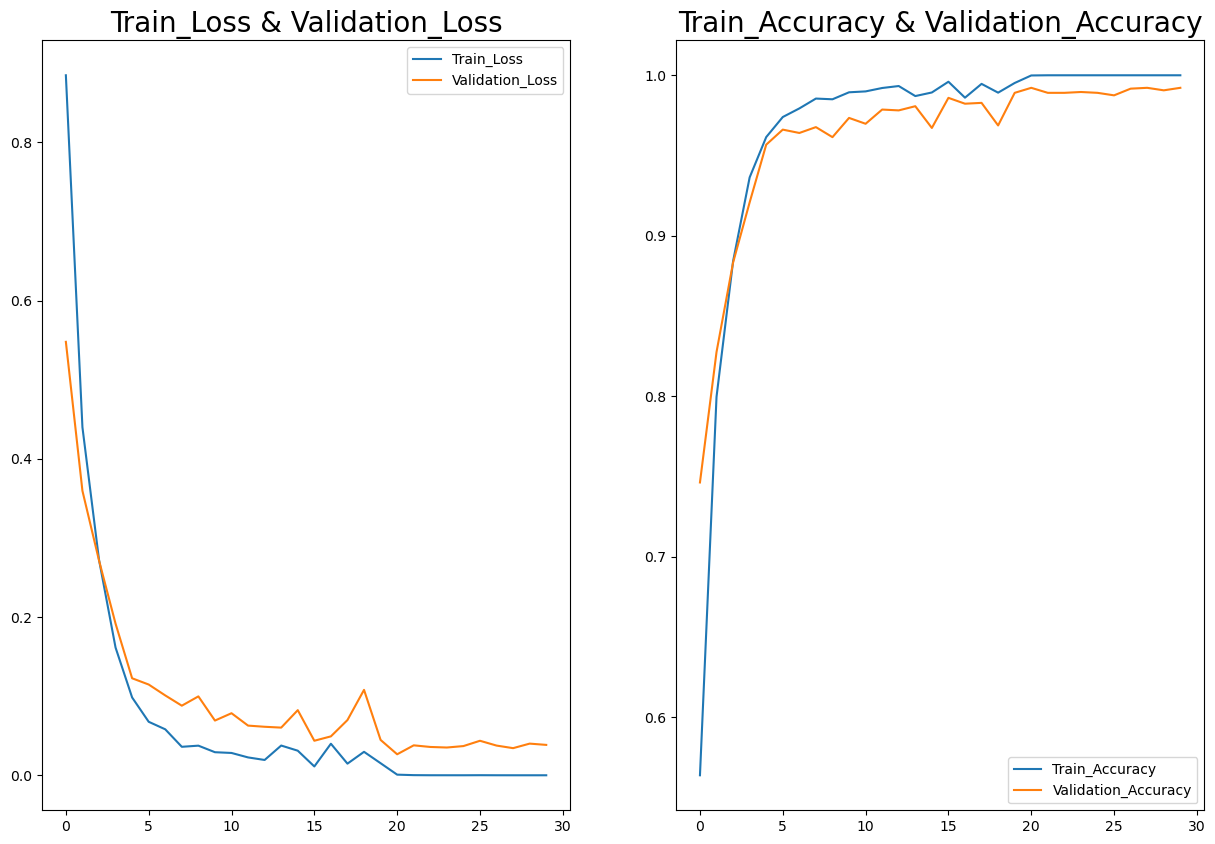

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [18]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9914 - loss: 0.0232
Test Loss = 0.022129986435174942
Test Accuracy = 0.9927083253860474


In [19]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


Actual  Prediction
0          1           1
1          1           1
2          0           0
3          2           2
4          2           2
...      ...         ...
1915       2           2
1916       0           0
1917       2           2
1918       3           3
1919       3           3

[1920 rows x 2 columns]

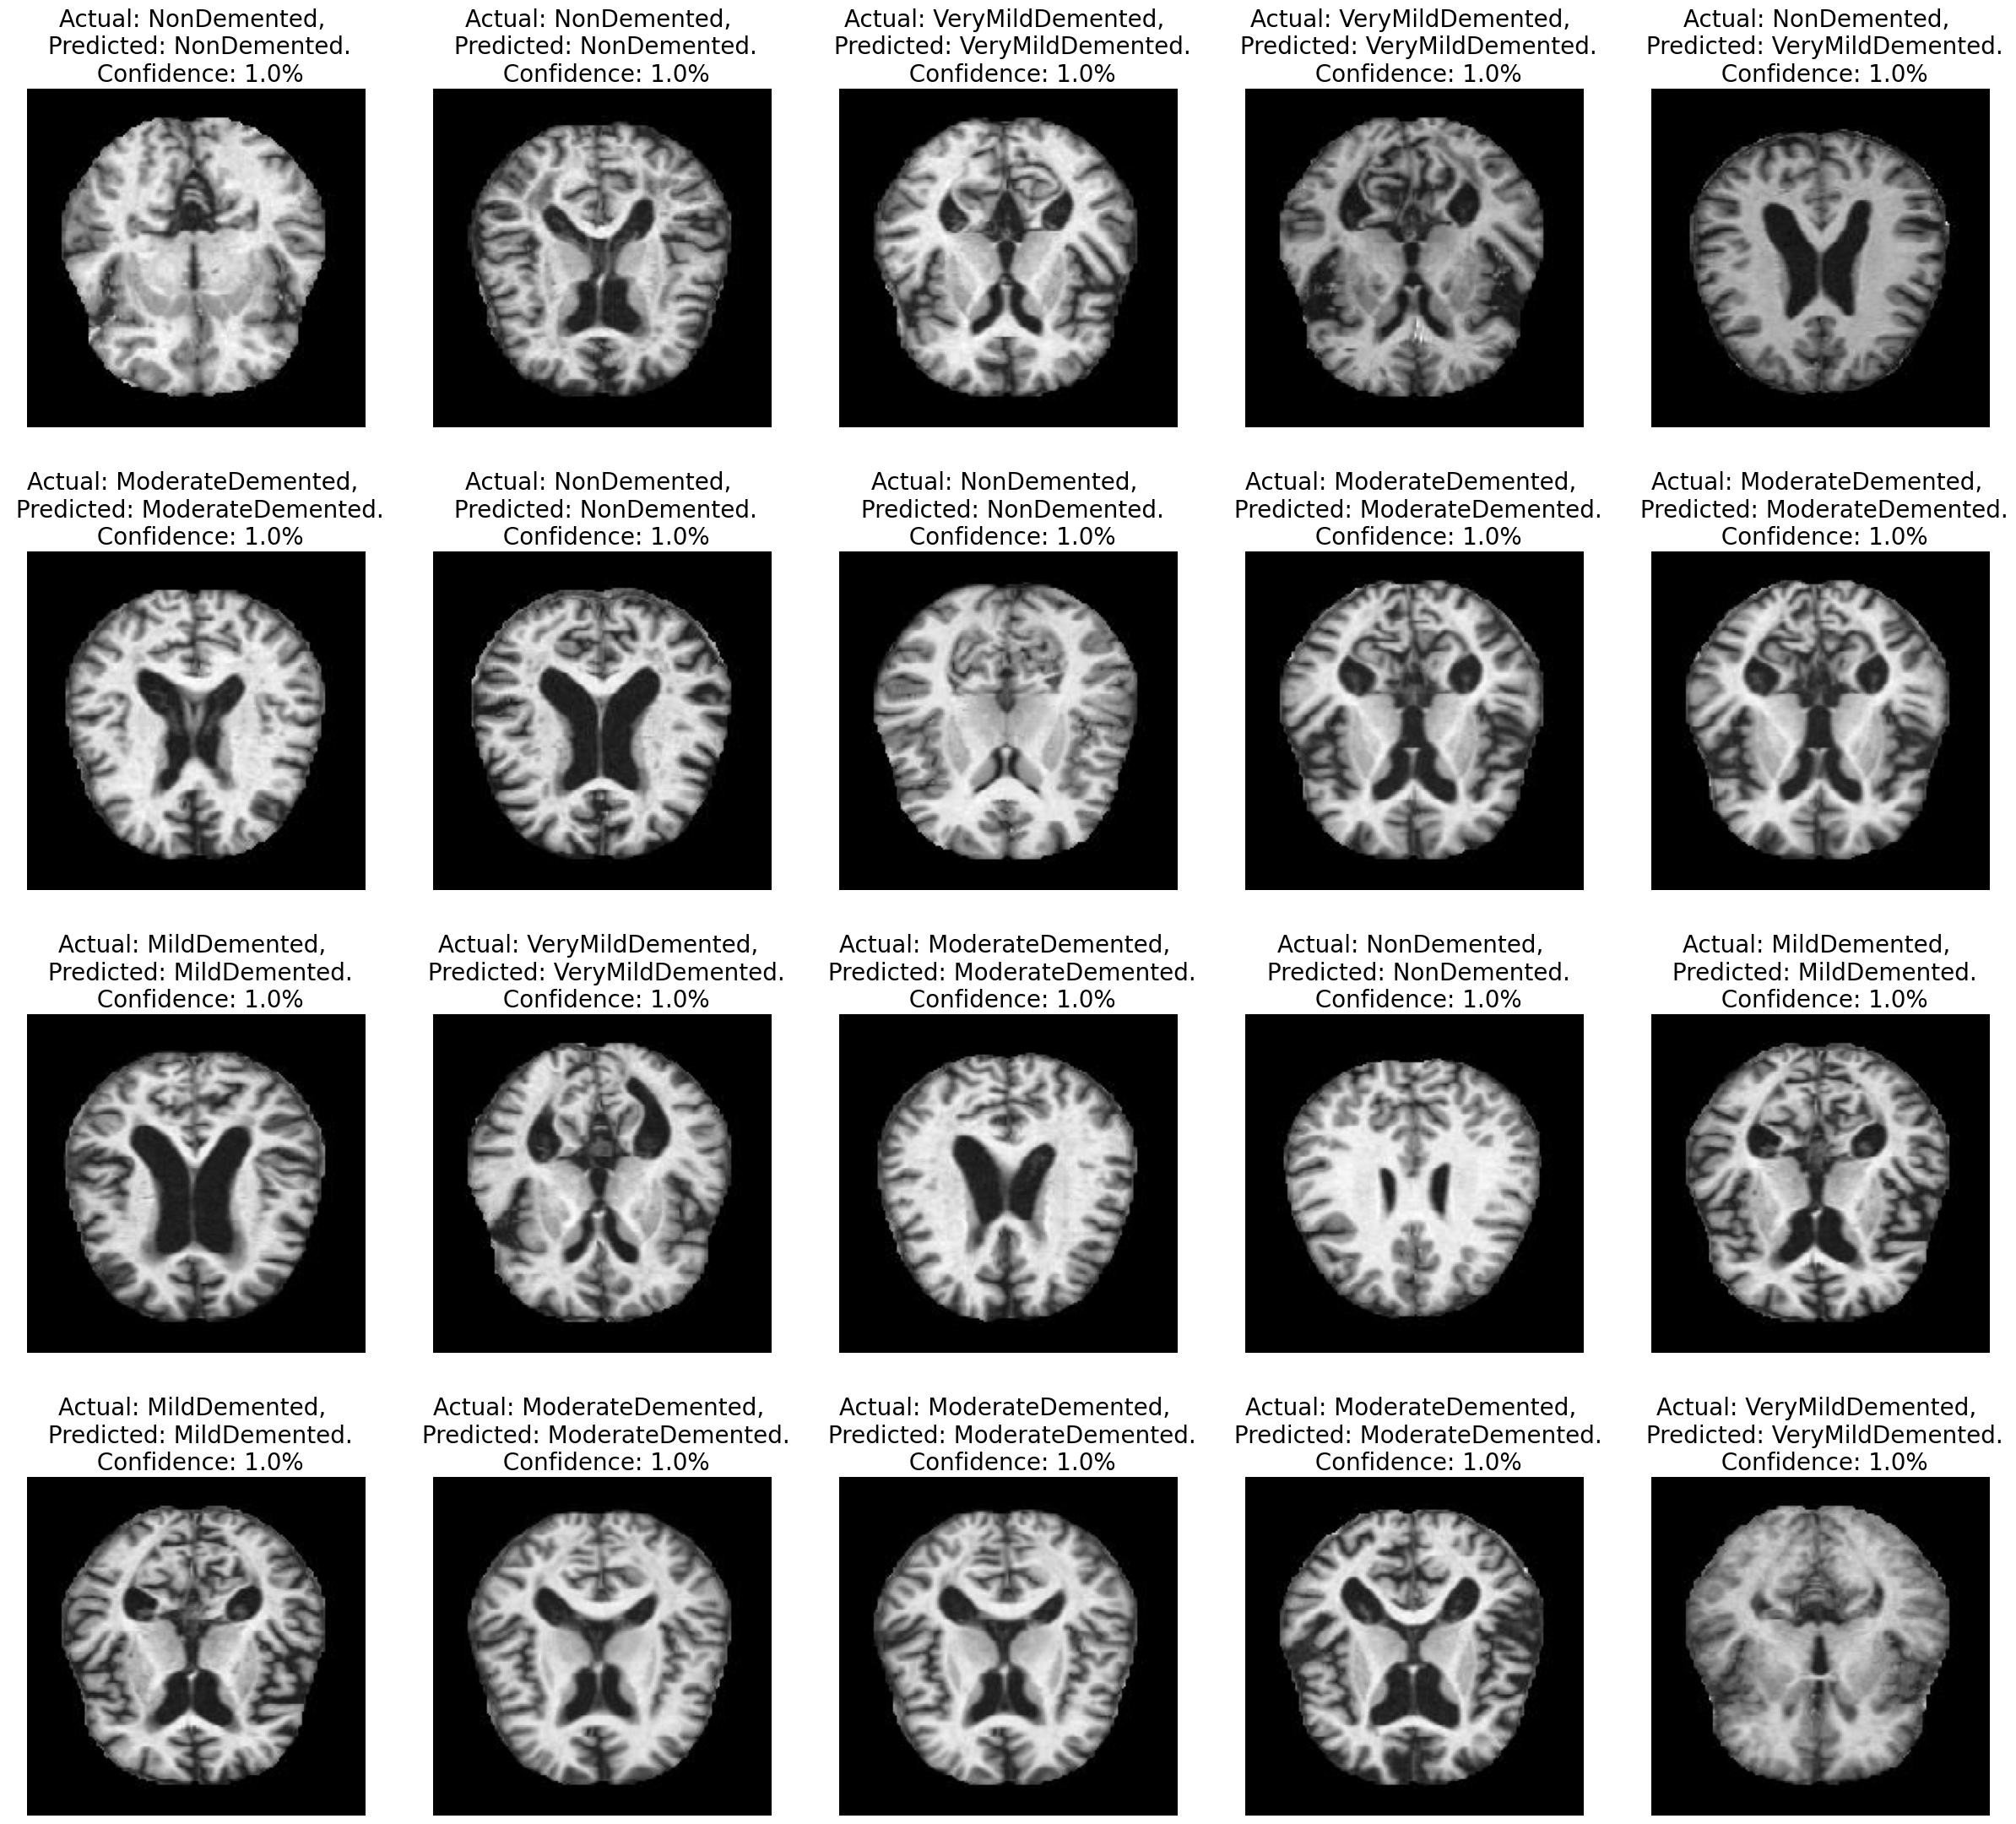

In [20]:
plt.figure(figsize=(30,70))
for n,i in enumerate(np.random.randint(0,len(X_test),20)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f"Actual: {class_num[y_test_[i]]}, \n Predicted: {class_num[y_pred[i]]}.\n Confidence: {round(predictions[i][np.argmax(predictions[i])],0)}%",fontsize=20)

array([[478,   0,   1,   1],
       [  0, 480,   0,   0],
       [  1,   0, 472,   7],
       [  0,   0,   4, 476]])

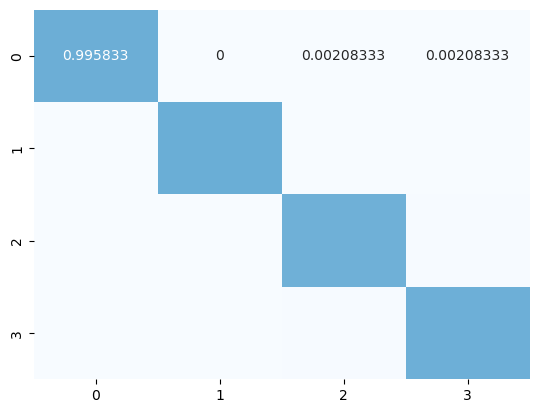

In [21]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [22]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       1.00      1.00      1.00       480
           1       1.00      1.00      1.00       480
           2       0.99      0.98      0.99       480
           3       0.98      0.99      0.99       480

    accuracy                           0.99      1920
   macro avg       0.99      0.99      0.99      1920
weighted avg       0.99      0.99      0.99      1920



RESNET50

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# Load and preprocess the data
# Assuming images are already loaded and preprocessed as numpy arrays and labels are in one-hot encoded format

# Define the model using ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(176, 176, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # Change 4 to the number of classes you have

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks
checkpoint_cb = ModelCheckpoint("ResNet50_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Fit the model
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])



Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 182, 182,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 88, 88,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 88, 88,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 88, 88,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 90, 90,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 44, 44,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 44, 44,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 44, 44,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 44, 44,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 44, 44,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 44, 44,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 44, 44,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 44, 44,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 44, 44,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 44, 44,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 44, 44,    │      1,024 │ conv2_block1_3_c

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 189s 664ms/step - accuracy: 0.3148 - loss: 1.4805 - val_accuracy: 0.5026 - val_loss: 1.1698
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 185s 661ms/step - accuracy: 0.4764 - loss: 1.1586 - val_accuracy: 0.5510 - val_loss: 1.0175
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 184s 657ms/step - accuracy: 0.5350 - loss: 1.0351 - val_accuracy: 0.5922 - val_loss: 0.9158
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 185s 662ms/step - accuracy: 0.5986 - loss: 0.8948 - val_accuracy: 0.6156 - val_loss: 0.8563
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 188s 673ms/step - accuracy: 0.6159 - loss: 0.8339 - val_accuracy: 0.6203 - val_loss: 0.8496
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 186s 663ms/step - accuracy: 0.6244 - loss: 0.8026 - val_accuracy: 0.6073 - val_loss: 0.8265
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 184s 658ms/step - accuracy: 0.6271 - loss: 0.7966 - val_accuracy: 0.5745 - val_loss: 0.8285
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 185s 661ms/step - accuracy: 0.6369 -

In [25]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.7642 - loss: 0.5341
Test Loss = 0.5361384749412537
Test Accuracy = 0.7557291388511658


In [26]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_test and X_test are available and preprocessed
# Predict the labels for the test set
y_pred = model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

print(report)


60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 461ms/step
                  precision    recall  f1-score   support

    MildDemented       0.73      0.77      0.75       480
ModerateDemented       0.99      1.00      1.00       480
     NonDemented       0.76      0.60      0.67       480
VeryMildDemented       0.57      0.65      0.61       480

        accuracy                           0.76      1920
       macro avg       0.76      0.76      0.76      1920
    weighted avg       0.76      0.76      0.76      1920



60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 464ms/step


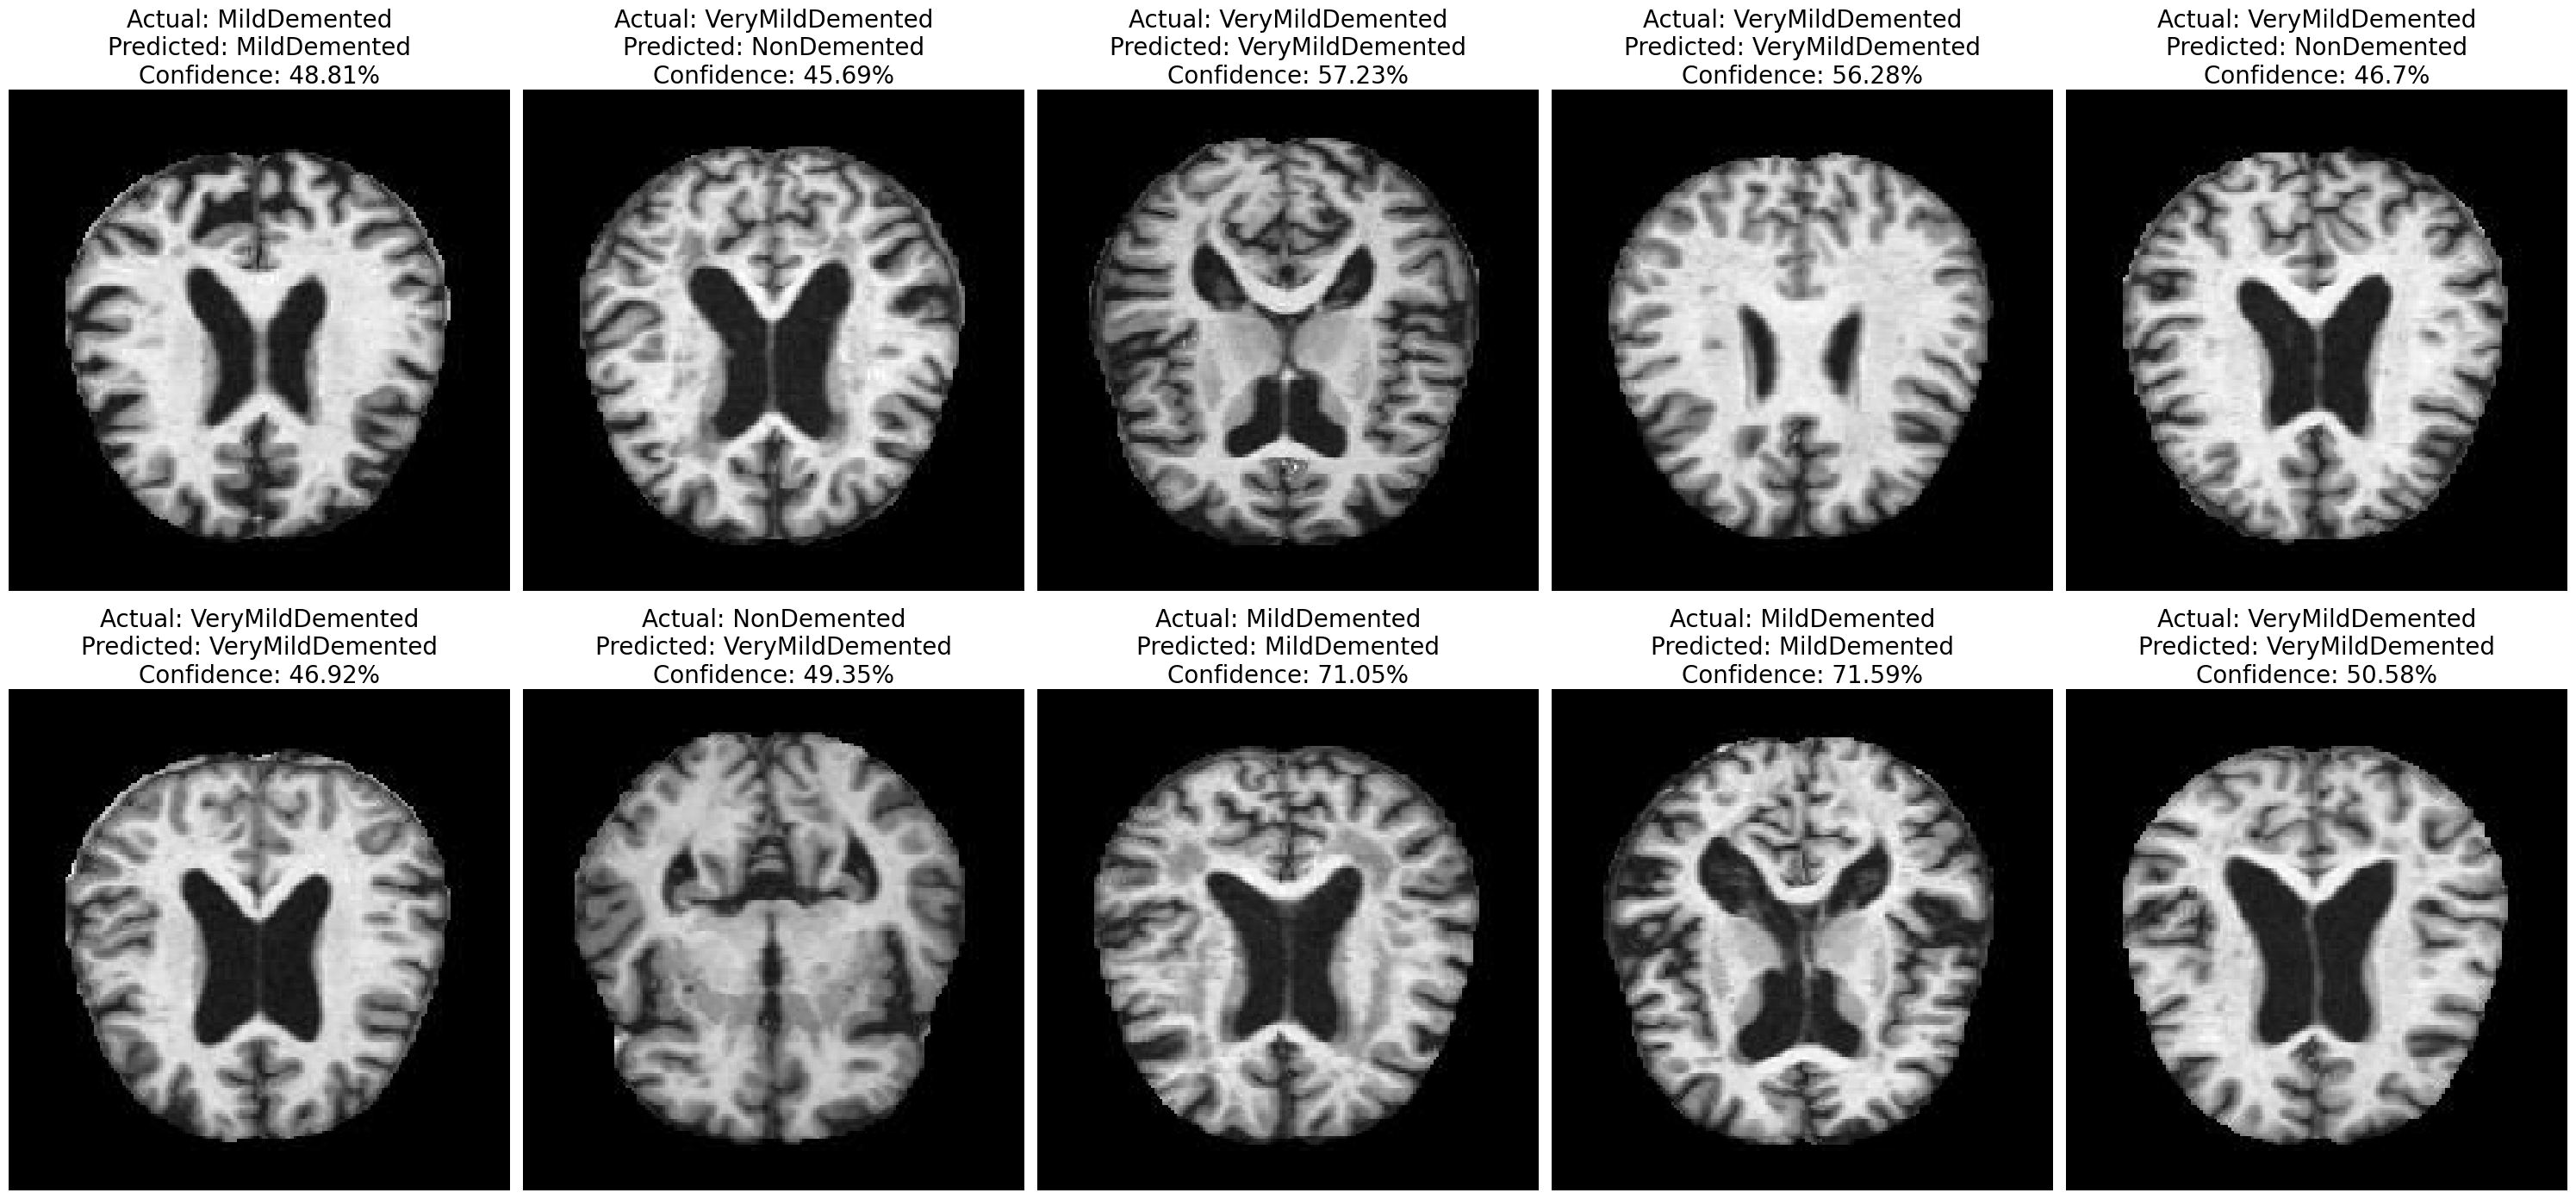

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test set
predictions = model.predict(X_test)

# Convert predictions and true labels to label indices
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Define class names (replace with actual class names)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plotting the images with their actual and predicted labels
plt.figure(figsize=(30, 70))
for n, i in enumerate(np.random.randint(0, len(X_test), 10)):
    plt.subplot(10, 5, n + 1)
    plt.imshow(X_test[i])
    plt.axis('off')
    actual_label = class_names[y_true_classes[i]]
    predicted_label = class_names[y_pred_classes[i]]
    confidence = round(predictions[i][y_pred_classes[i]] * 100, 2)  # Confidence in percentage
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence}%", fontsize=20)

plt.tight_layout()
plt.show()


RESNET101

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# Load and preprocess the data
# Assuming images are already loaded and preprocessed as numpy arrays and labels are in one-hot encoded format

# Define the model using ResNet101
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(176, 176, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # Adjust the number of classes as needed

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks
checkpoint_cb = ModelCheckpoint("ResNet101_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Fit the model
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 182, 182,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 88, 88,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 88, 88,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 88, 88,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 90, 90,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 44, 44,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 44, 44,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 44, 44,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 44, 44,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 44, 44,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 44, 44,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 44, 44,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 44, 44,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 44, 44,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 44, 44,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 44, 44,    │      1,024 │ conv2_block1_3_c

 Total params: 44,760,452 (170.75 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.3246 - loss: 1.9036 - val_accuracy: 0.5266 - val_loss: 1.1406
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.5187 - loss: 1.1154 - val_accuracy: 0.6010 - val_loss: 0.9543
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.5752 - loss: 0.9642 - val_accuracy: 0.5766 - val_loss: 0.9484
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.5988 - loss: 0.9021 - val_accuracy: 0.5828 - val_loss: 0.9686
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.6246 - loss: 0.8380 - val_accuracy: 0.6229 - val_loss: 0.8598
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.6130 - loss: 0.8259 - val_accuracy: 0.6391 - val_loss: 0.7850
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.6466 - loss: 0.7759 - val_accuracy: 0.6552 - val_loss: 0.7694
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.6375 - loss: 0.7908 - val_accu

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test set
predictions = model.predict(X_test)

# Convert predictions and true labels to label indices
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Define class names (replace with actual class names)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plotting the images with their actual and predicted labels
plt.figure(figsize=(30, 70))
for n, i in enumerate(np.random.randint(0, len(X_test), 10)):
    plt.subplot(10, 5, n + 1)
    plt.imshow(X_test[i])
    plt.axis('off')
    actual_label = class_names[y_true_classes[i]]
    predicted_label = class_names[y_pred_classes[i]]
    confidence = round(predictions[i][y_pred_classes[i]] * 100, 2)  # Confidence in percentage
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence}%", fontsize=20)

plt.tight_layout()
plt.show()


VGG16

In [32]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# Load and preprocess the data
# Assuming images are already loaded and preprocessed as numpy arrays and labels are in one-hot encoded format

# Define the model using VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(176, 176, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # Adjust the number of classes as needed

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks
checkpoint_cb = ModelCheckpoint("VGG16_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Fit the model
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 176, 176, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 176, 176, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 176, 176, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 88, 88, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 88, 88, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 88, 88, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 44, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 44, 44, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 44, 44, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 44, 44, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,244,100 (58.15 MB)

 Trainable params: 529,412 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.4696 - loss: 1.2111 - val_accuracy: 0.6094 - val_loss: 0.8638
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.6951 - loss: 0.7203 - val_accuracy: 0.7068 - val_loss: 0.6784
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.7255 - loss: 0.6251 - val_accuracy: 0.6917 - val_loss: 0.6964
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.7438 - loss: 0.5798 - val_accuracy: 0.7443 - val_loss: 0.5568
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.7556 - loss: 0.5562 - val_accuracy: 0.7453 - val_loss: 0.5432
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.7703 - loss: 0.5255 - val_accuracy: 0.7745 - val_loss: 0.5183
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.7956 - loss: 0.4833 - val_accuracy: 0.7740 - val_loss: 0.5049
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.8078 - loss: 0.4585 - val_accu

In [34]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9433 - loss: 0.1494
Test Loss = 0.14214666187763214
Test Accuracy = 0.9442708492279053


In [36]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_test and X_test are available and preprocessed
# Predict the labels for the test set
y_pred = model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

print(report)

60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step
                  precision    recall  f1-score   support

    MildDemented       0.97      0.96      0.97       480
ModerateDemented       1.00      1.00      1.00       480
     NonDemented       0.89      0.93      0.91       480
VeryMildDemented       0.92      0.89      0.90       480

        accuracy                           0.94      1920
       macro avg       0.94      0.94      0.94      1920
    weighted avg       0.94      0.94      0.94      1920



60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step


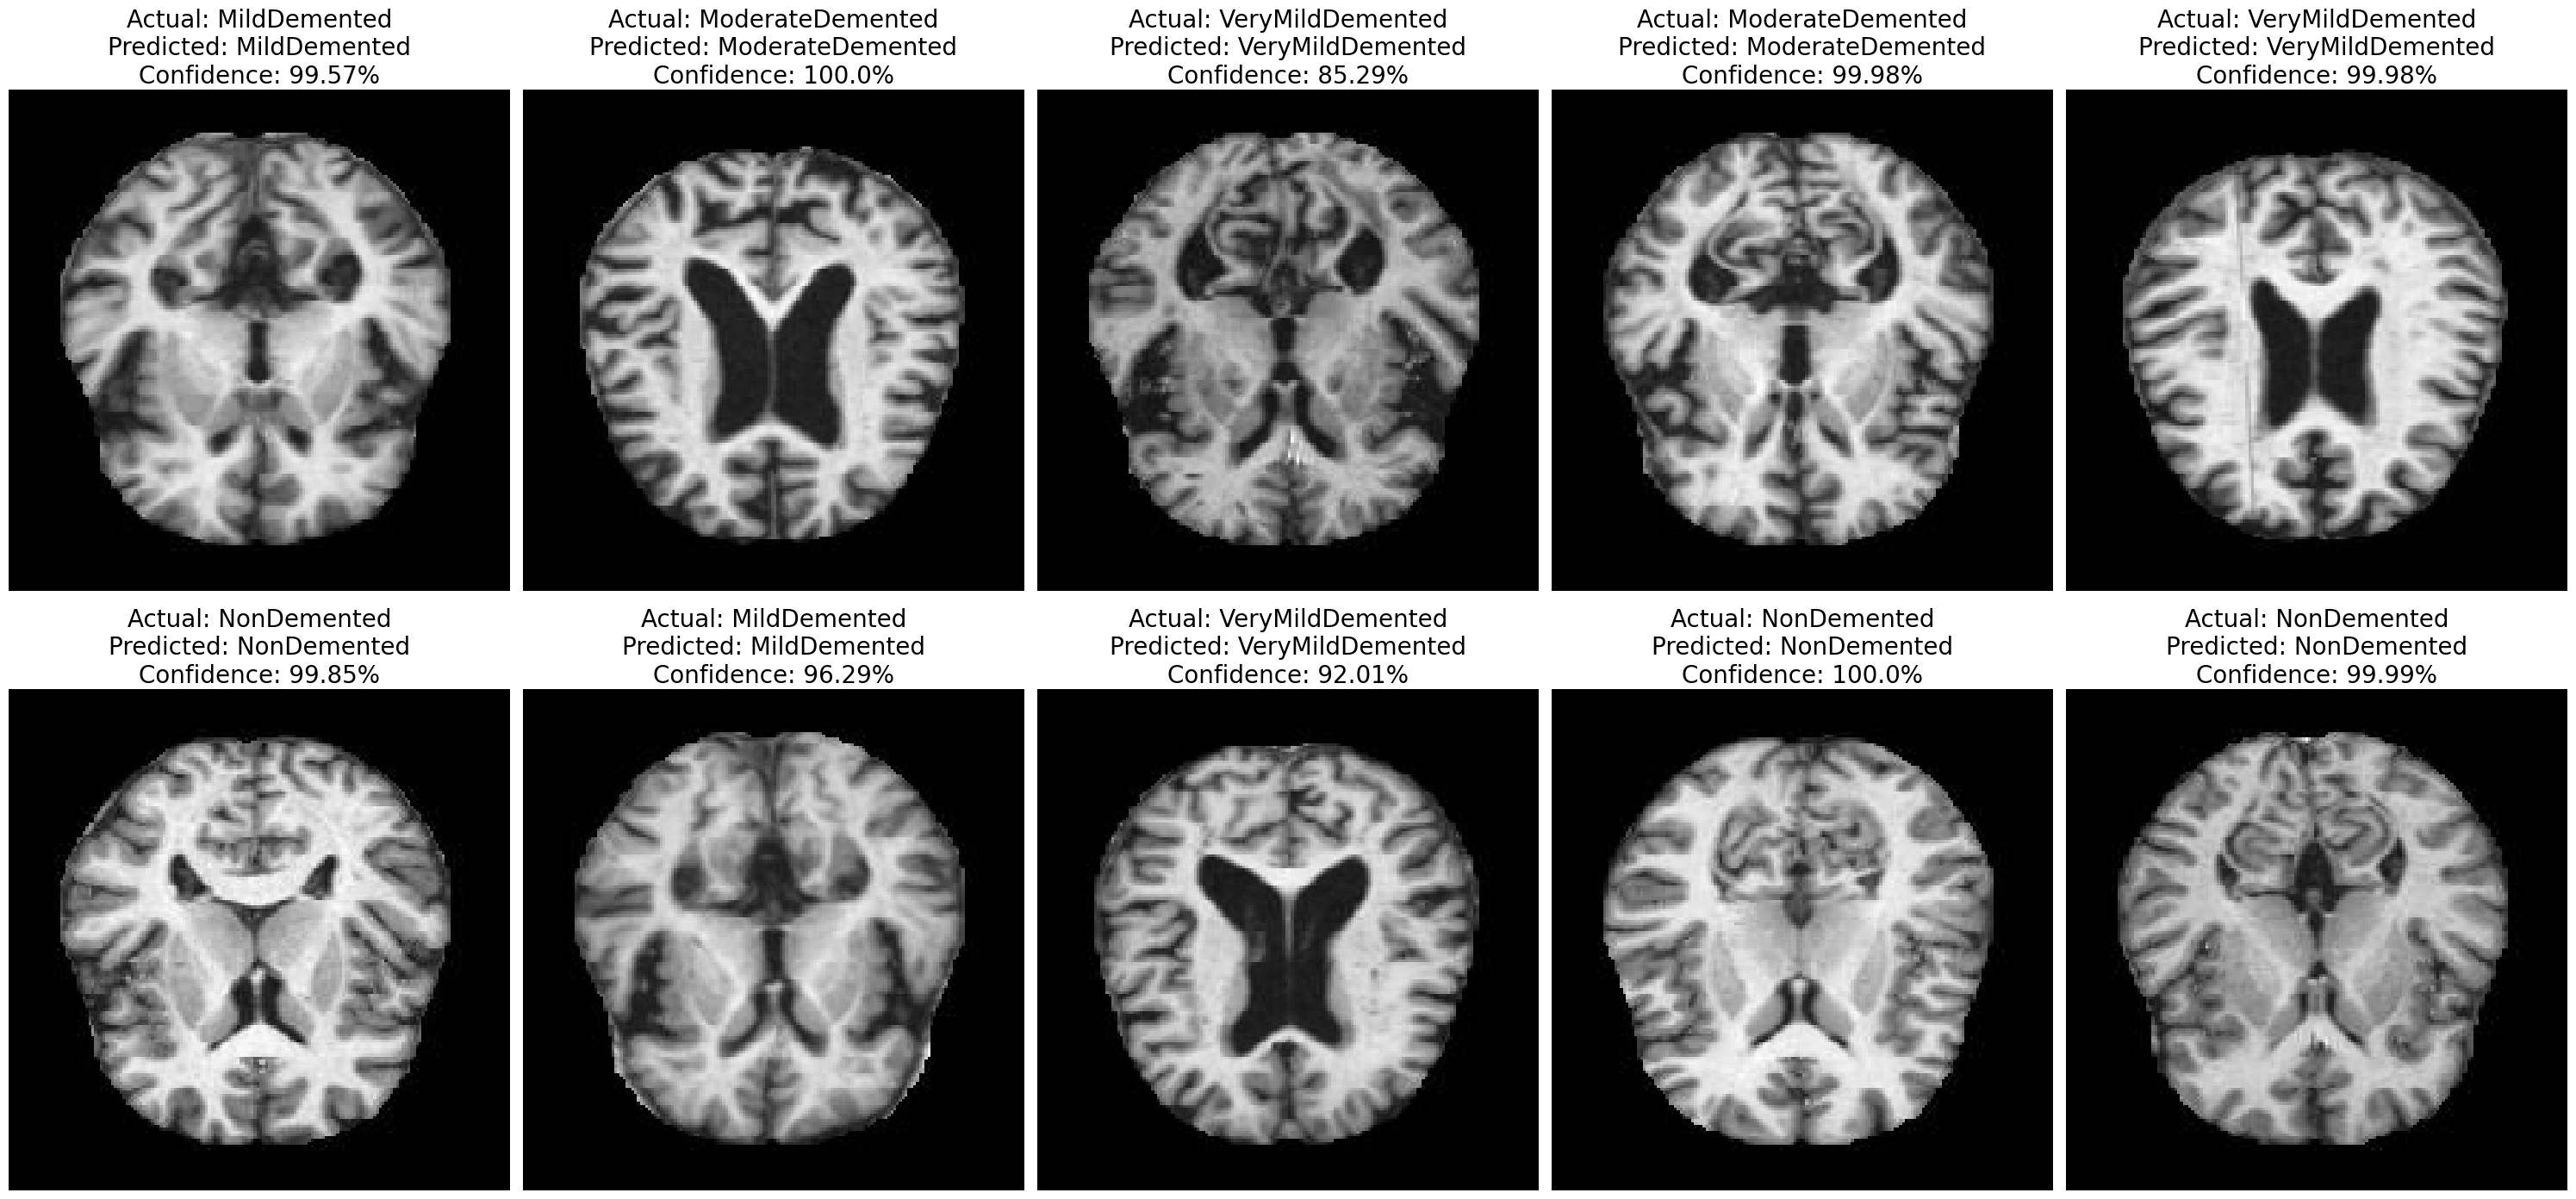

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test set
predictions = model.predict(X_test)

# Convert predictions and true labels to label indices
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Define class names (replace with actual class names)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plotting the images with their actual and predicted labels
plt.figure(figsize=(30, 70))
for n, i in enumerate(np.random.randint(0, len(X_test), 10)):
    plt.subplot(10, 5, n + 1)
    plt.imshow(X_test[i])
    plt.axis('off')
    actual_label = class_names[y_true_classes[i]]
    predicted_label = class_names[y_pred_classes[i]]
    confidence = round(predictions[i][y_pred_classes[i]] * 100, 2)  # Confidence in percentage
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence}%", fontsize=20)

plt.tight_layout()
plt.show()


VGG19

In [41]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# Load and preprocess the data
# Assuming images are already loaded and preprocessed as numpy arrays and labels are in one-hot encoded format

# Define the model using VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(176, 176, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # Adjust the number of classes as needed

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks
checkpoint_cb = ModelCheckpoint("VGG19_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Fit the model
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 176, 176, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 176, 176, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 176, 176, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 88, 88, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 88, 88, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 88, 88, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 44, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 44, 44, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 44, 44, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 44, 44, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 44, 44, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,553,796 (78.41 MB)

 Trainable params: 529,412 (2.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.4333 - loss: 1.2322 - val_accuracy: 0.6130 - val_loss: 0.8583
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - accuracy: 0.6610 - loss: 0.7823 - val_accuracy: 0.6182 - val_loss: 0.8159
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - accuracy: 0.6974 - loss: 0.6775 - val_accuracy: 0.7104 - val_loss: 0.6390
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.7206 - loss: 0.6317 - val_accuracy: 0.7198 - val_loss: 0.6113
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - accuracy: 0.7311 - loss: 0.6069 - val_accuracy: 0.7427 - val_loss: 0.5979
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - accuracy: 0.7270 - loss: 0.6084 - val_accuracy: 0.7583 - val_loss: 0.5746
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.7598 - loss: 0.5607 - val_accuracy: 0.7047 - val_loss: 0.6016
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.7674 - loss: 0.5291 - val_accu

In [46]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9362 - loss: 0.1630
Test Loss = 0.16574600338935852
Test Accuracy = 0.9354166388511658


In [48]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_test and X_test are available and preprocessed
# Predict the labels for the test set
y_pred = model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

print(report)

60/60 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step
                  precision    recall  f1-score   support

    MildDemented       0.94      0.97      0.96       480
ModerateDemented       1.00      1.00      1.00       480
     NonDemented       0.88      0.92      0.90       480
VeryMildDemented       0.93      0.85      0.89       480

        accuracy                           0.94      1920
       macro avg       0.94      0.94      0.94      1920
    weighted avg       0.94      0.94      0.94      1920



60/60 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step


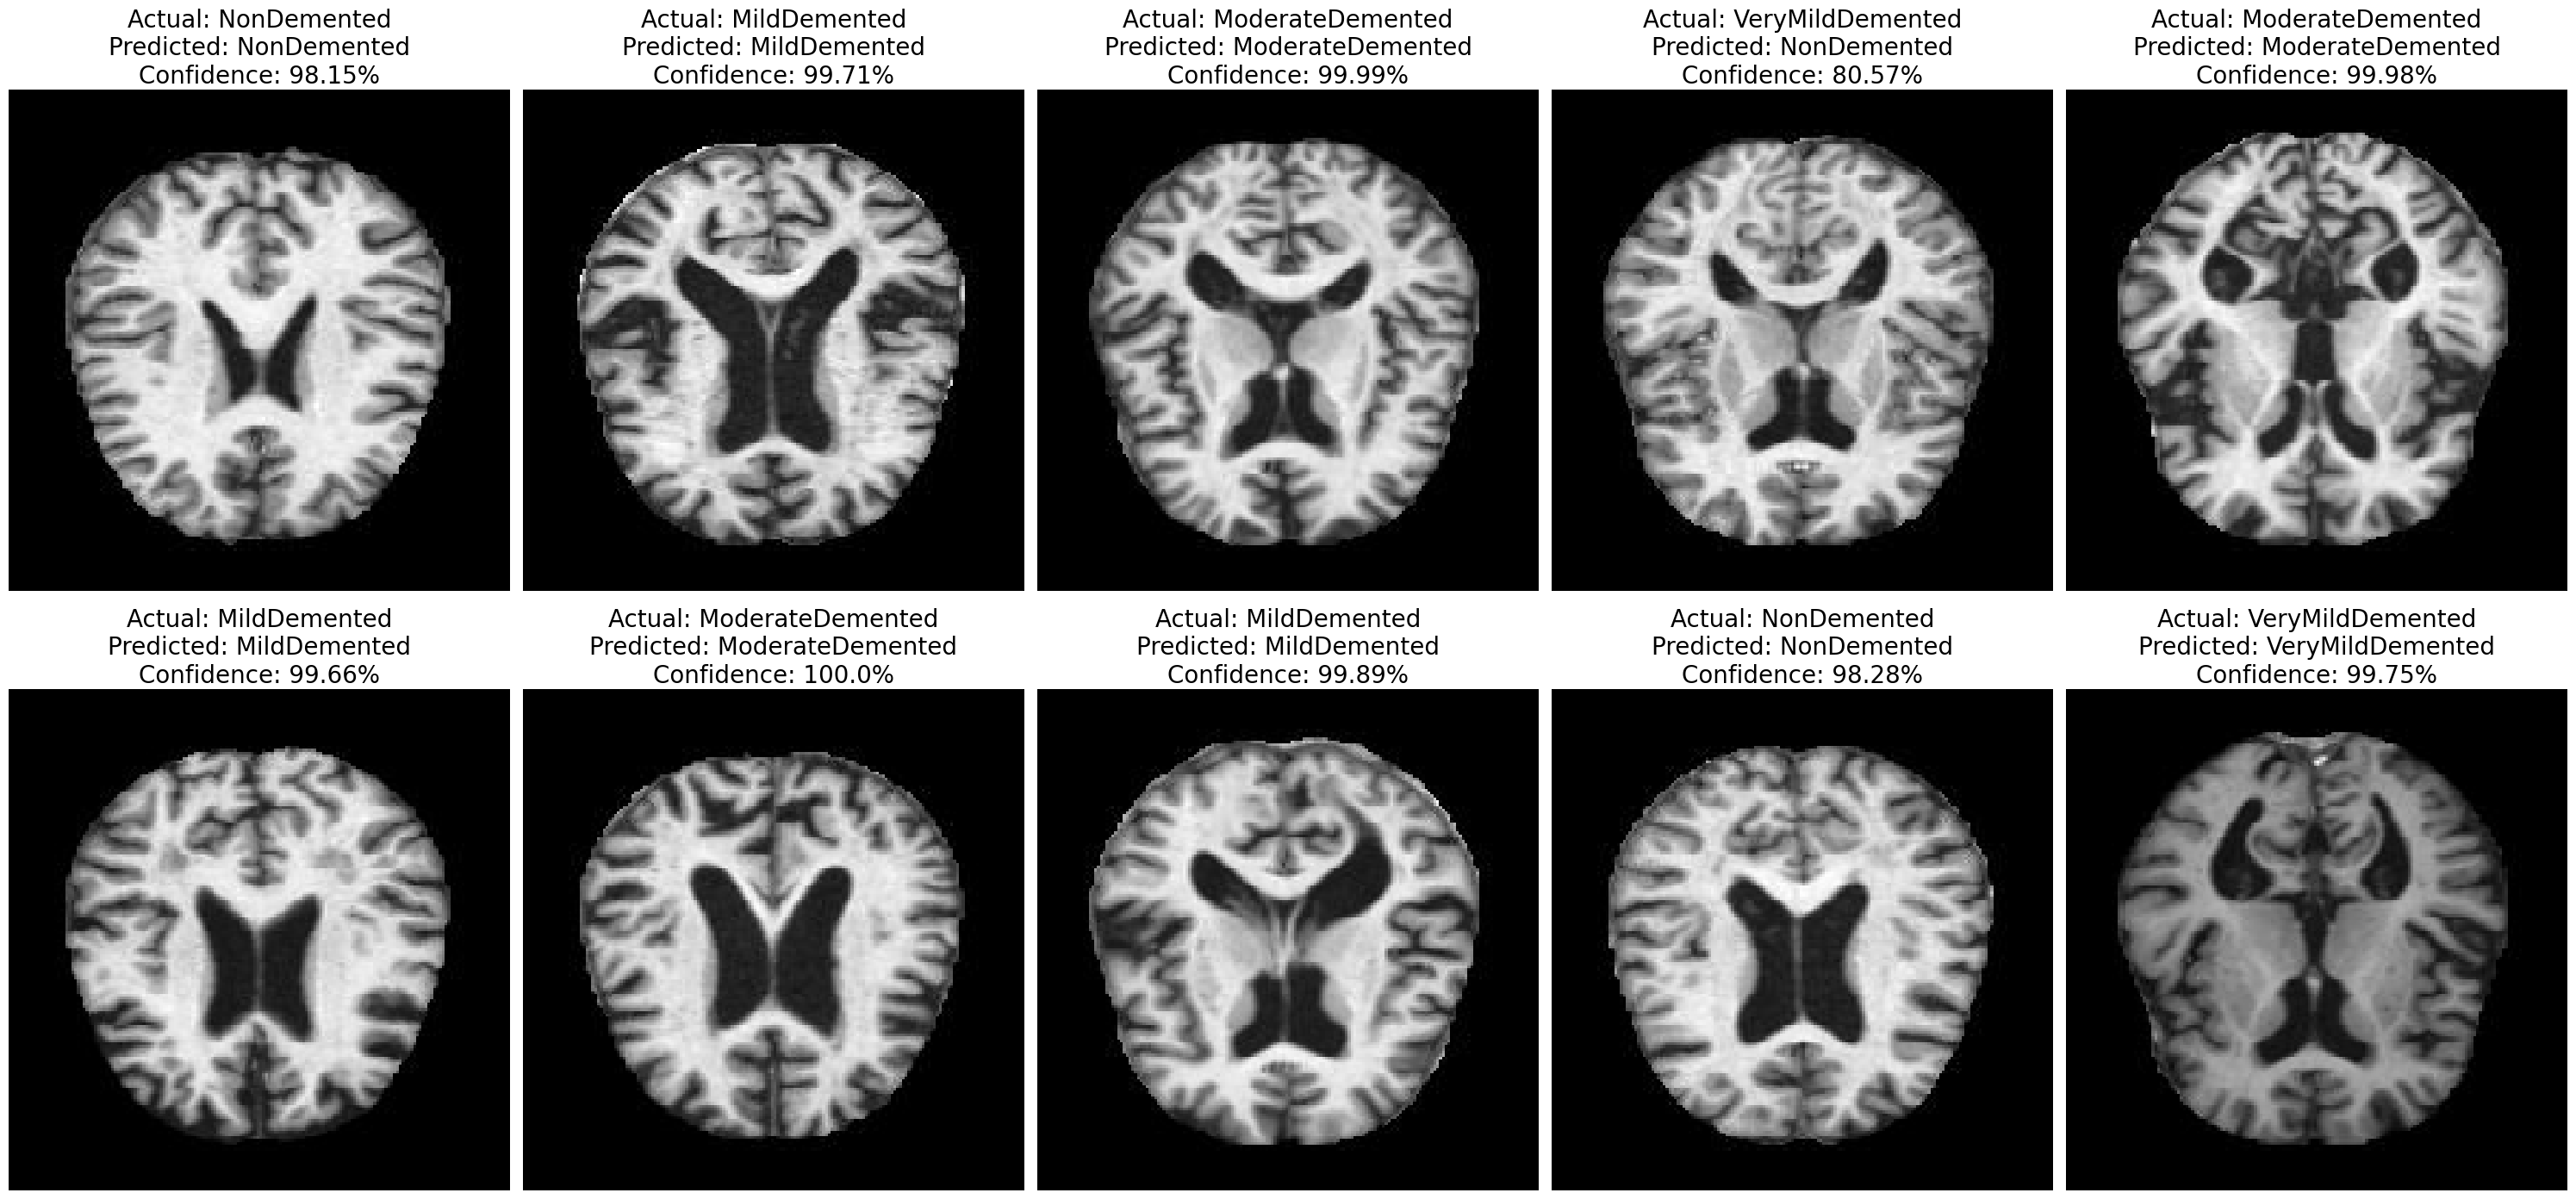

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test set
predictions = model.predict(X_test)

# Convert predictions and true labels to label indices
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Define class names (replace with actual class names)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plotting the images with their actual and predicted labels
plt.figure(figsize=(30, 70))
for n, i in enumerate(np.random.randint(0, len(X_test), 10)):
    plt.subplot(10, 5, n + 1)
    plt.imshow(X_test[i])
    plt.axis('off')
    actual_label = class_names[y_true_classes[i]]
    predicted_label = class_names[y_pred_classes[i]]
    confidence = round(predictions[i][y_pred_classes[i]] * 100, 2)  # Confidence in percentage
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence}%", fontsize=20)

plt.tight_layout()
plt.show()

INCEPTIONV3

In [52]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# Load and preprocess the data
# Assuming images are already loaded and preprocessed as numpy arrays and labels are in one-hot encoded format

# Define the model using InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(176, 176, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # Adjust the number of classes as needed

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks
checkpoint_cb = ModelCheckpoint("InceptionV3_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Fit the model
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 87, 87,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 87, 87,    │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 87, 87,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 85, 85,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 85, 85,    │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 85, 85,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 85, 85,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 85, 85,    │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 85, 85,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 42, 42,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 42, 42,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 42, 42,    │        240 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 42, 42,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 40, 40,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        576 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 116s 405ms/step - accuracy: 0.4989 - loss: 1.8858 - val_accuracy: 0.6578 - val_loss: 0.8726
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 110s 394ms/step - accuracy: 0.6942 - loss: 0.6812 - val_accuracy: 0.7286 - val_loss: 0.6089
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 112s 400ms/step - accuracy: 0.7449 - loss: 0.5769 - val_accuracy: 0.7505 - val_loss: 0.5567
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 111s 396ms/step - accuracy: 0.7775 - loss: 0.5098 - val_accuracy: 0.7323 - val_loss: 0.5891
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 111s 396ms/step - accuracy: 0.7838 - loss: 0.4903 - val_accuracy: 0.7880 - val_loss: 0.4781
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 111s 397ms/step - accuracy: 0.8054 - loss: 0.4491 - val_accuracy: 0.7911 - val_loss: 0.4866
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 112s 399ms/step - accuracy: 0.8238 - loss: 0.4237 - val_accuracy: 0.7839 - val_loss: 0.4586
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 112s 399ms/step - accuracy: 0.8380 -

In [54]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 377ms/step - accuracy: 0.9199 - loss: 0.2908
Test Loss = 0.2521054446697235
Test Accuracy = 0.9208333492279053


In [56]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_test and X_test are available and preprocessed
# Predict the labels for the test set
y_pred = model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

print(report)

60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 384ms/step
                  precision    recall  f1-score   support

    MildDemented       0.94      0.97      0.95       480
ModerateDemented       1.00      0.99      1.00       480
     NonDemented       0.90      0.84      0.87       480
VeryMildDemented       0.84      0.89      0.86       480

        accuracy                           0.92      1920
       macro avg       0.92      0.92      0.92      1920
    weighted avg       0.92      0.92      0.92      1920



60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 375ms/step


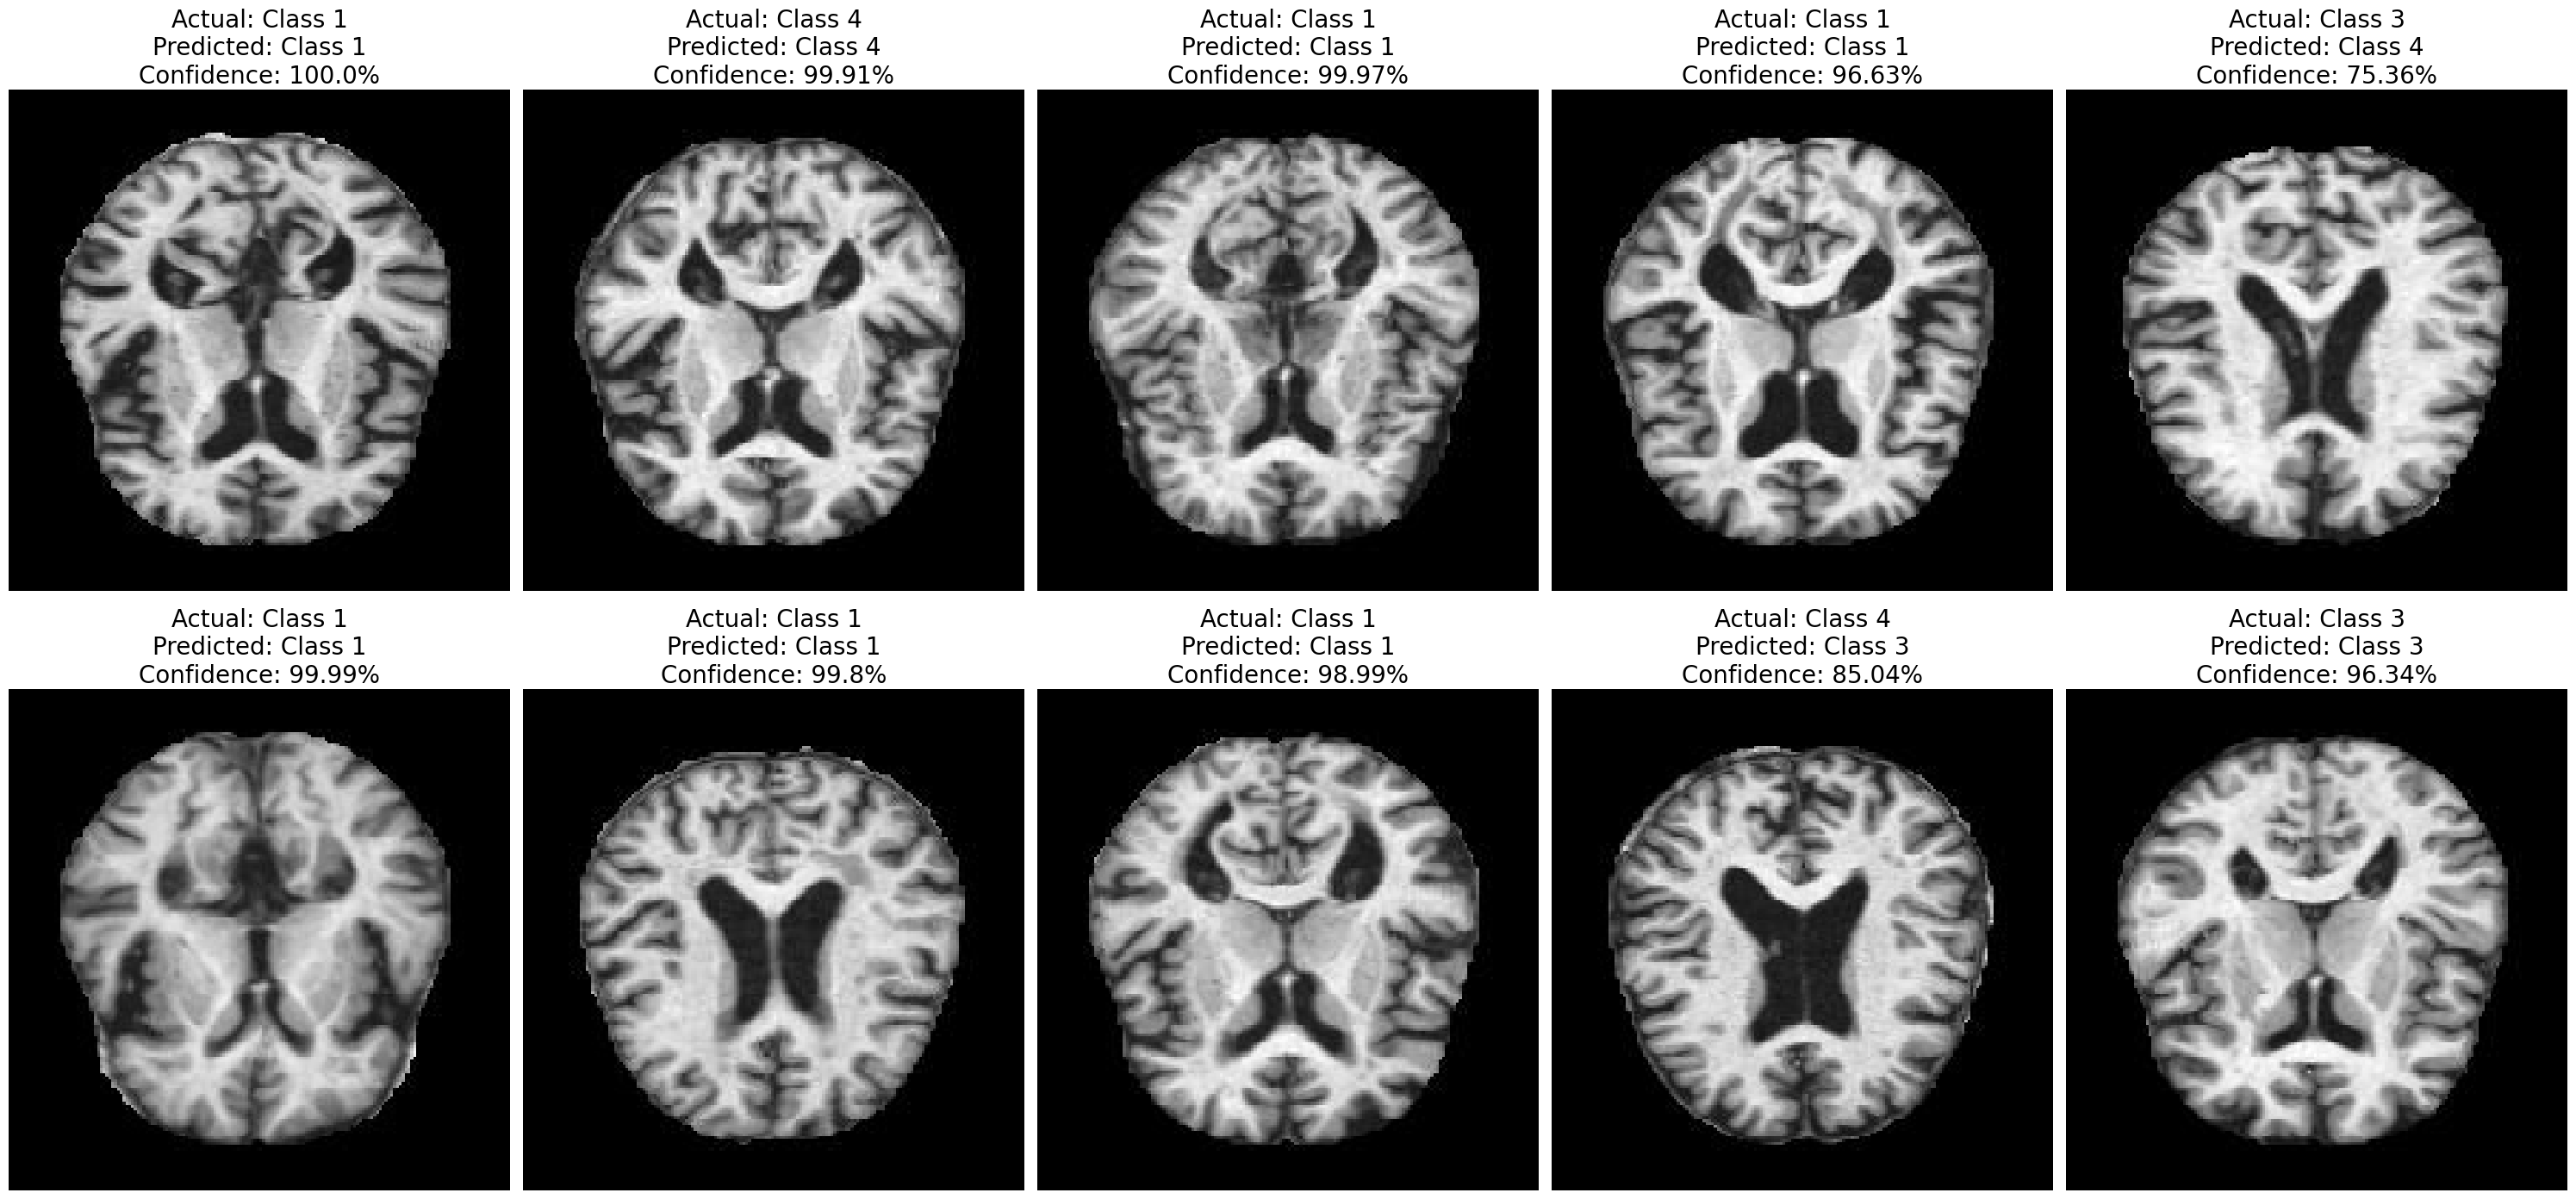

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test set
predictions = model.predict(X_test)

# Convert predictions and true labels to label indices
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Define class names (replace with actual class names)
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

# Plotting the images with their actual and predicted labels
plt.figure(figsize=(30, 70))
for n, i in enumerate(np.random.randint(0, len(X_test), 10)):
    plt.subplot(10, 5, n + 1)
    plt.imshow(X_test[i])
    plt.axis('off')
    actual_label = class_names[y_true_classes[i]]
    predicted_label = class_names[y_pred_classes[i]]
    confidence = round(predictions[i][y_pred_classes[i]] * 100, 2)  # Confidence in percentage
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence}%", fontsize=20)

plt.tight_layout()
plt.show()


XCEPTION

In [60]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# Load and preprocess the data
# Assuming images are already loaded and preprocessed as numpy arrays and labels are in one-hot encoded format

# Define the model using Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(176, 176, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # Adjust the number of classes as needed

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks
checkpoint_cb = ModelCheckpoint("Xception_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Fit the model
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 87, 87,    │        864 │ input_layer_7[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 87, 87,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 87, 87,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 85, 85,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 85, 85,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 85, 85,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 85, 85,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 85, 85,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 85, 85,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 85, 85,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 85, 85,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 43, 43,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 43, 43,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 43, 43,    │        512 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 43, 43,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 43, 43,    │          0 │ add[0][0]       

 Total params: 22,963,756 (87.60 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 206s 729ms/step - accuracy: 0.5454 - loss: 1.0813 - val_accuracy: 0.7031 - val_loss: 0.6667
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 201s 719ms/step - accuracy: 0.7031 - loss: 0.6581 - val_accuracy: 0.7271 - val_loss: 0.5859
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 203s 724ms/step - accuracy: 0.7383 - loss: 0.5817 - val_accuracy: 0.7089 - val_loss: 0.6433
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 203s 724ms/step - accuracy: 0.7614 - loss: 0.5452 - val_accuracy: 0.7391 - val_loss: 0.5961
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 202s 722ms/step - accuracy: 0.7896 - loss: 0.4838 - val_accuracy: 0.7589 - val_loss: 0.5250
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 202s 722ms/step - accuracy: 0.8144 - loss: 0.4323 - val_accuracy: 0.8089 - val_loss: 0.4515
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 202s 723ms/step - accuracy: 0.8338 - loss: 0.3898 - val_accuracy: 0.7708 - val_loss: 0.5025
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 203s 724ms/step - accuracy: 0.8468 -

In [62]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 506ms/step - accuracy: 0.9049 - loss: 0.2388
Test Loss = 0.23583979904651642
Test Accuracy = 0.9098958373069763


In [64]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_test and X_test are available and preprocessed
# Predict the labels for the test set
y_pred = model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

print(report)

60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 507ms/step
                  precision    recall  f1-score   support

    MildDemented       0.92      0.96      0.94       480
ModerateDemented       1.00      1.00      1.00       480
     NonDemented       0.87      0.83      0.85       480
VeryMildDemented       0.85      0.85      0.85       480

        accuracy                           0.91      1920
       macro avg       0.91      0.91      0.91      1920
    weighted avg       0.91      0.91      0.91      1920



60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 508ms/step


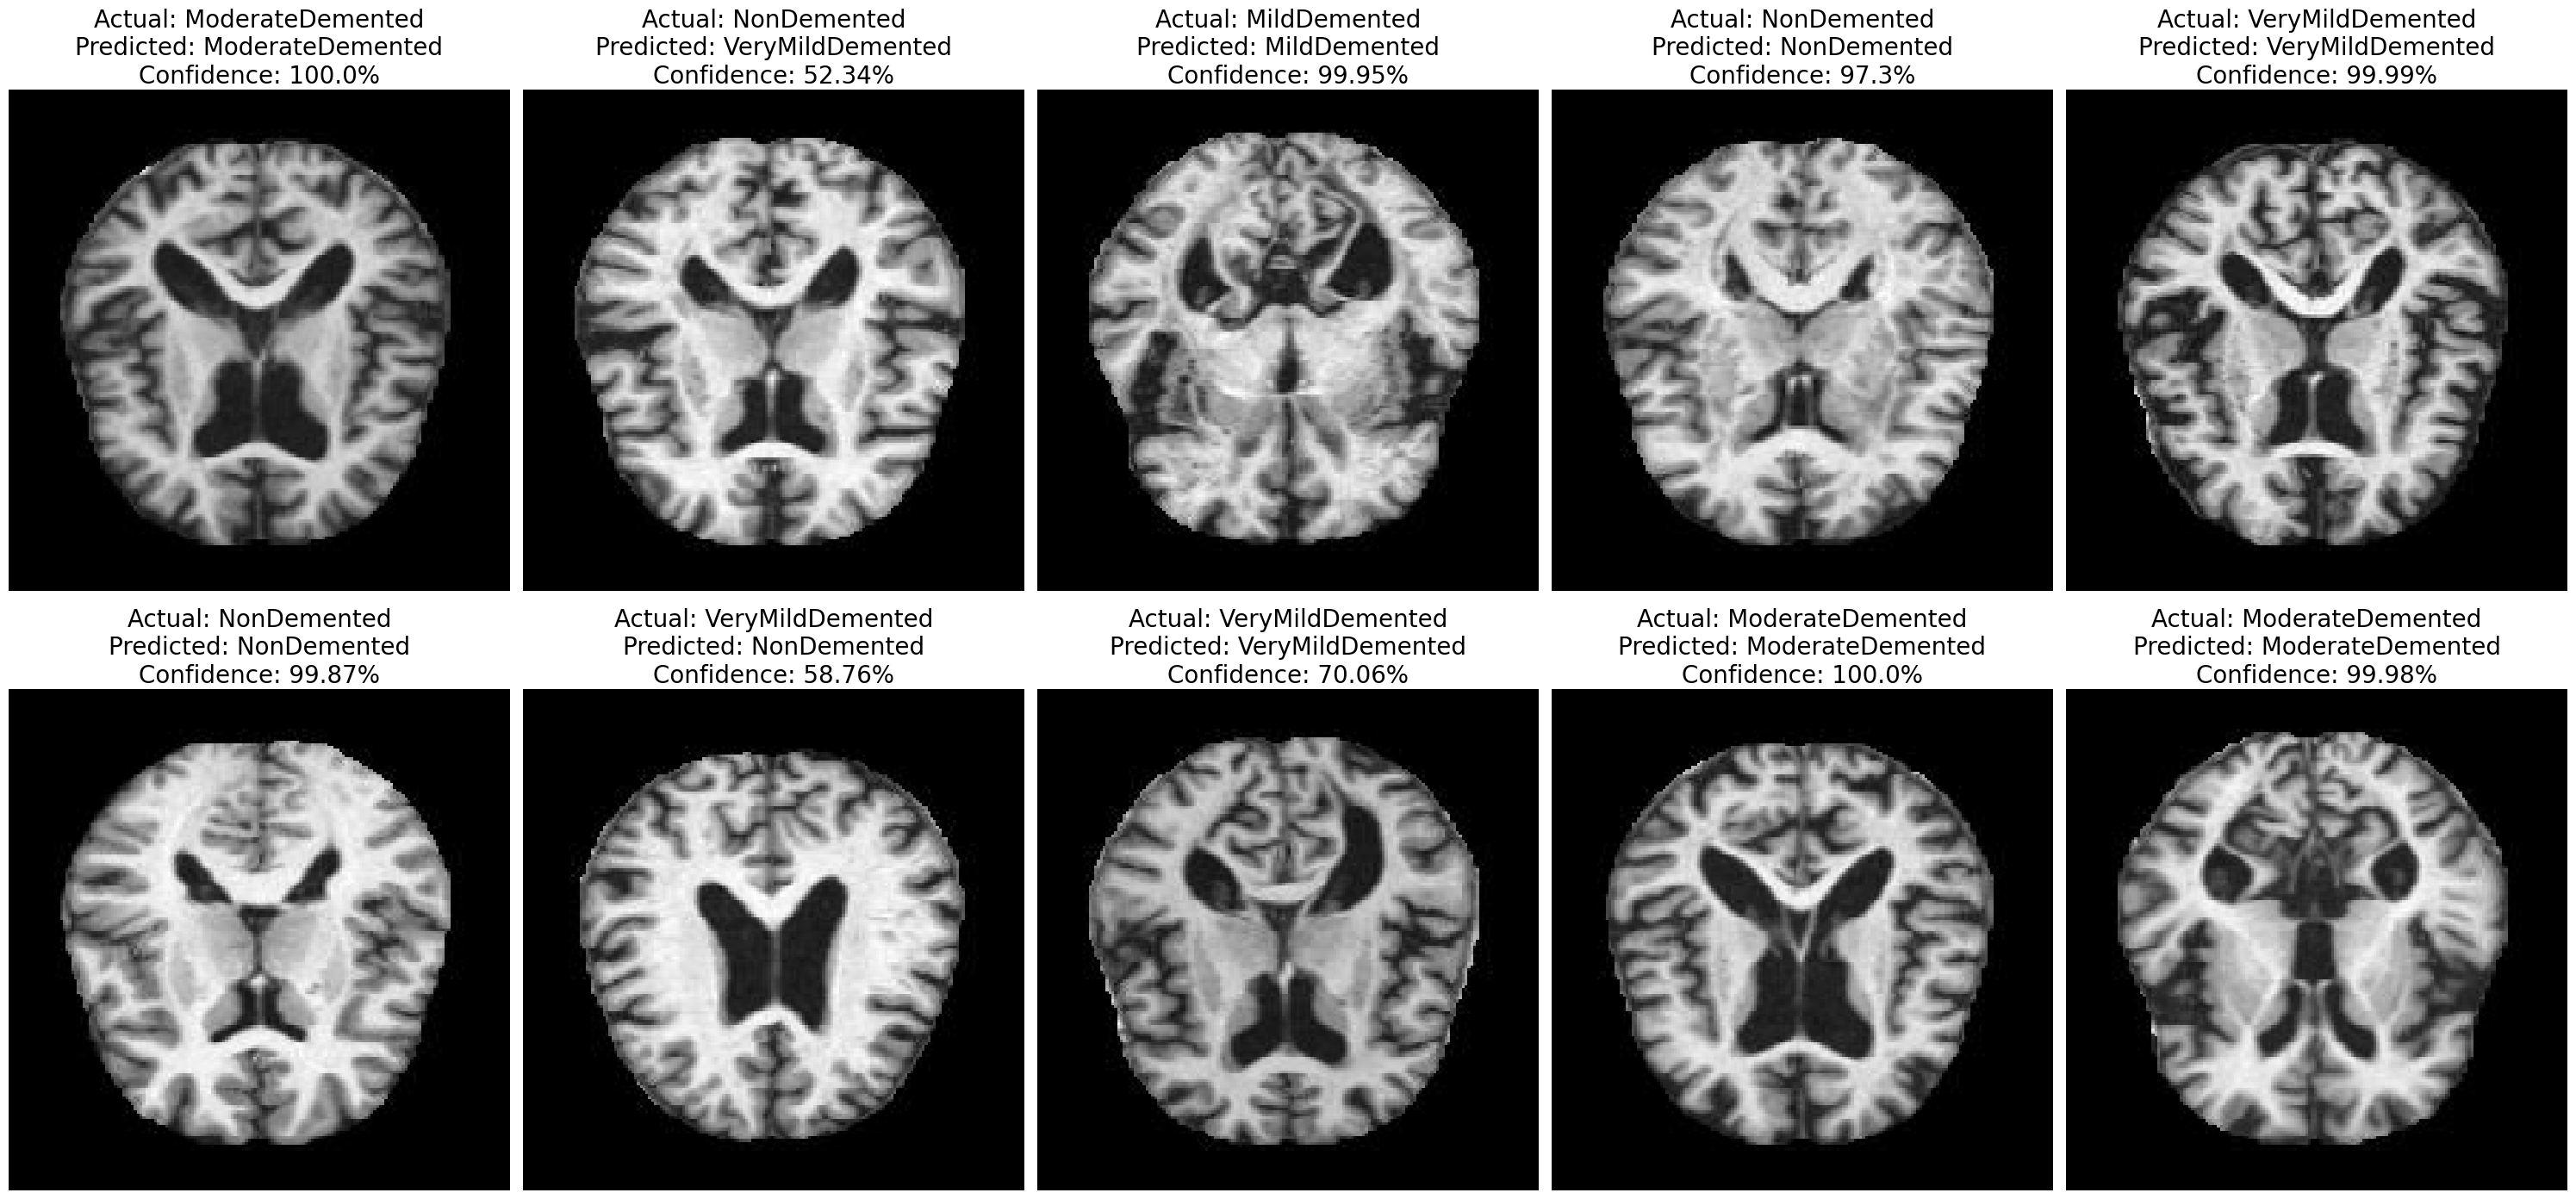

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test set
predictions = model.predict(X_test)

# Convert predictions and true labels to label indices
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Define class names (replace with actual class names)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plotting the images with their actual and predicted labels
plt.figure(figsize=(30, 70))
for n, i in enumerate(np.random.randint(0, len(X_test), 10)):
    plt.subplot(10, 5, n + 1)
    plt.imshow(X_test[i])
    plt.axis('off')
    actual_label = class_names[y_true_classes[i]]
    predicted_label = class_names[y_pred_classes[i]]
    confidence = round(predictions[i][y_pred_classes[i]] * 100, 2)  # Confidence in percentage
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence}%", fontsize=20)

plt.tight_layout()
plt.show()


DENSENET169

In [68]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# Load and preprocess the data
# Assuming images are already loaded and preprocessed as numpy arrays and labels are in one-hot encoded format

# Define the model using DenseNet169
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(176, 176, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # Adjust the number of classes as needed

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks
checkpoint_cb = ModelCheckpoint("DenseNet169_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Fit the model
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 182, 182,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 88, 88,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 88, 88,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 88, 88,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 90, 90,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 44, 44,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 44, 44,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 44, 44,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 44, 44,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 44, 44,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 44, 44,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 44, 44,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 44, 44,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 44, 44,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 44, 44,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 44, 44,    │     12,288 │ conv2_block2_0_r

 Total params: 14,351,940 (54.75 MB)

 Trainable params: 1,709,060 (6.52 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 198s 686ms/step - accuracy: 0.5162 - loss: 1.7137 - val_accuracy: 0.6635 - val_loss: 0.7746
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 190s 680ms/step - accuracy: 0.7115 - loss: 0.6480 - val_accuracy: 0.7260 - val_loss: 0.5989
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 193s 690ms/step - accuracy: 0.7687 - loss: 0.5347 - val_accuracy: 0.7797 - val_loss: 0.5047
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 195s 698ms/step - accuracy: 0.7888 - loss: 0.4803 - val_accuracy: 0.7823 - val_loss: 0.5180
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 195s 696ms/step - accuracy: 0.8091 - loss: 0.4510 - val_accuracy: 0.8188 - val_loss: 0.4333
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 192s 685ms/step - accuracy: 0.8283 - loss: 0.3964 - val_accuracy: 0.8208 - val_loss: 0.3981
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 194s 694ms/step - accuracy: 0.8342 - loss: 0.3856 - val_accuracy: 0.8417 - val_loss: 0.3710
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 191s 683ms/step - accuracy: 0.8545 -

In [70]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 565ms/step - accuracy: 0.9456 - loss: 0.1713
Test Loss = 0.1653592884540558
Test Accuracy = 0.9473958611488342


In [72]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_test and X_test are available and preprocessed
# Predict the labels for the test set
y_pred = model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

print(report)

60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 601ms/step
                  precision    recall  f1-score   support

    MildDemented       0.97      0.98      0.97       480
ModerateDemented       1.00      1.00      1.00       480
     NonDemented       0.90      0.93      0.91       480
VeryMildDemented       0.93      0.89      0.91       480

        accuracy                           0.95      1920
       macro avg       0.95      0.95      0.95      1920
    weighted avg       0.95      0.95      0.95      1920



60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 617ms/step


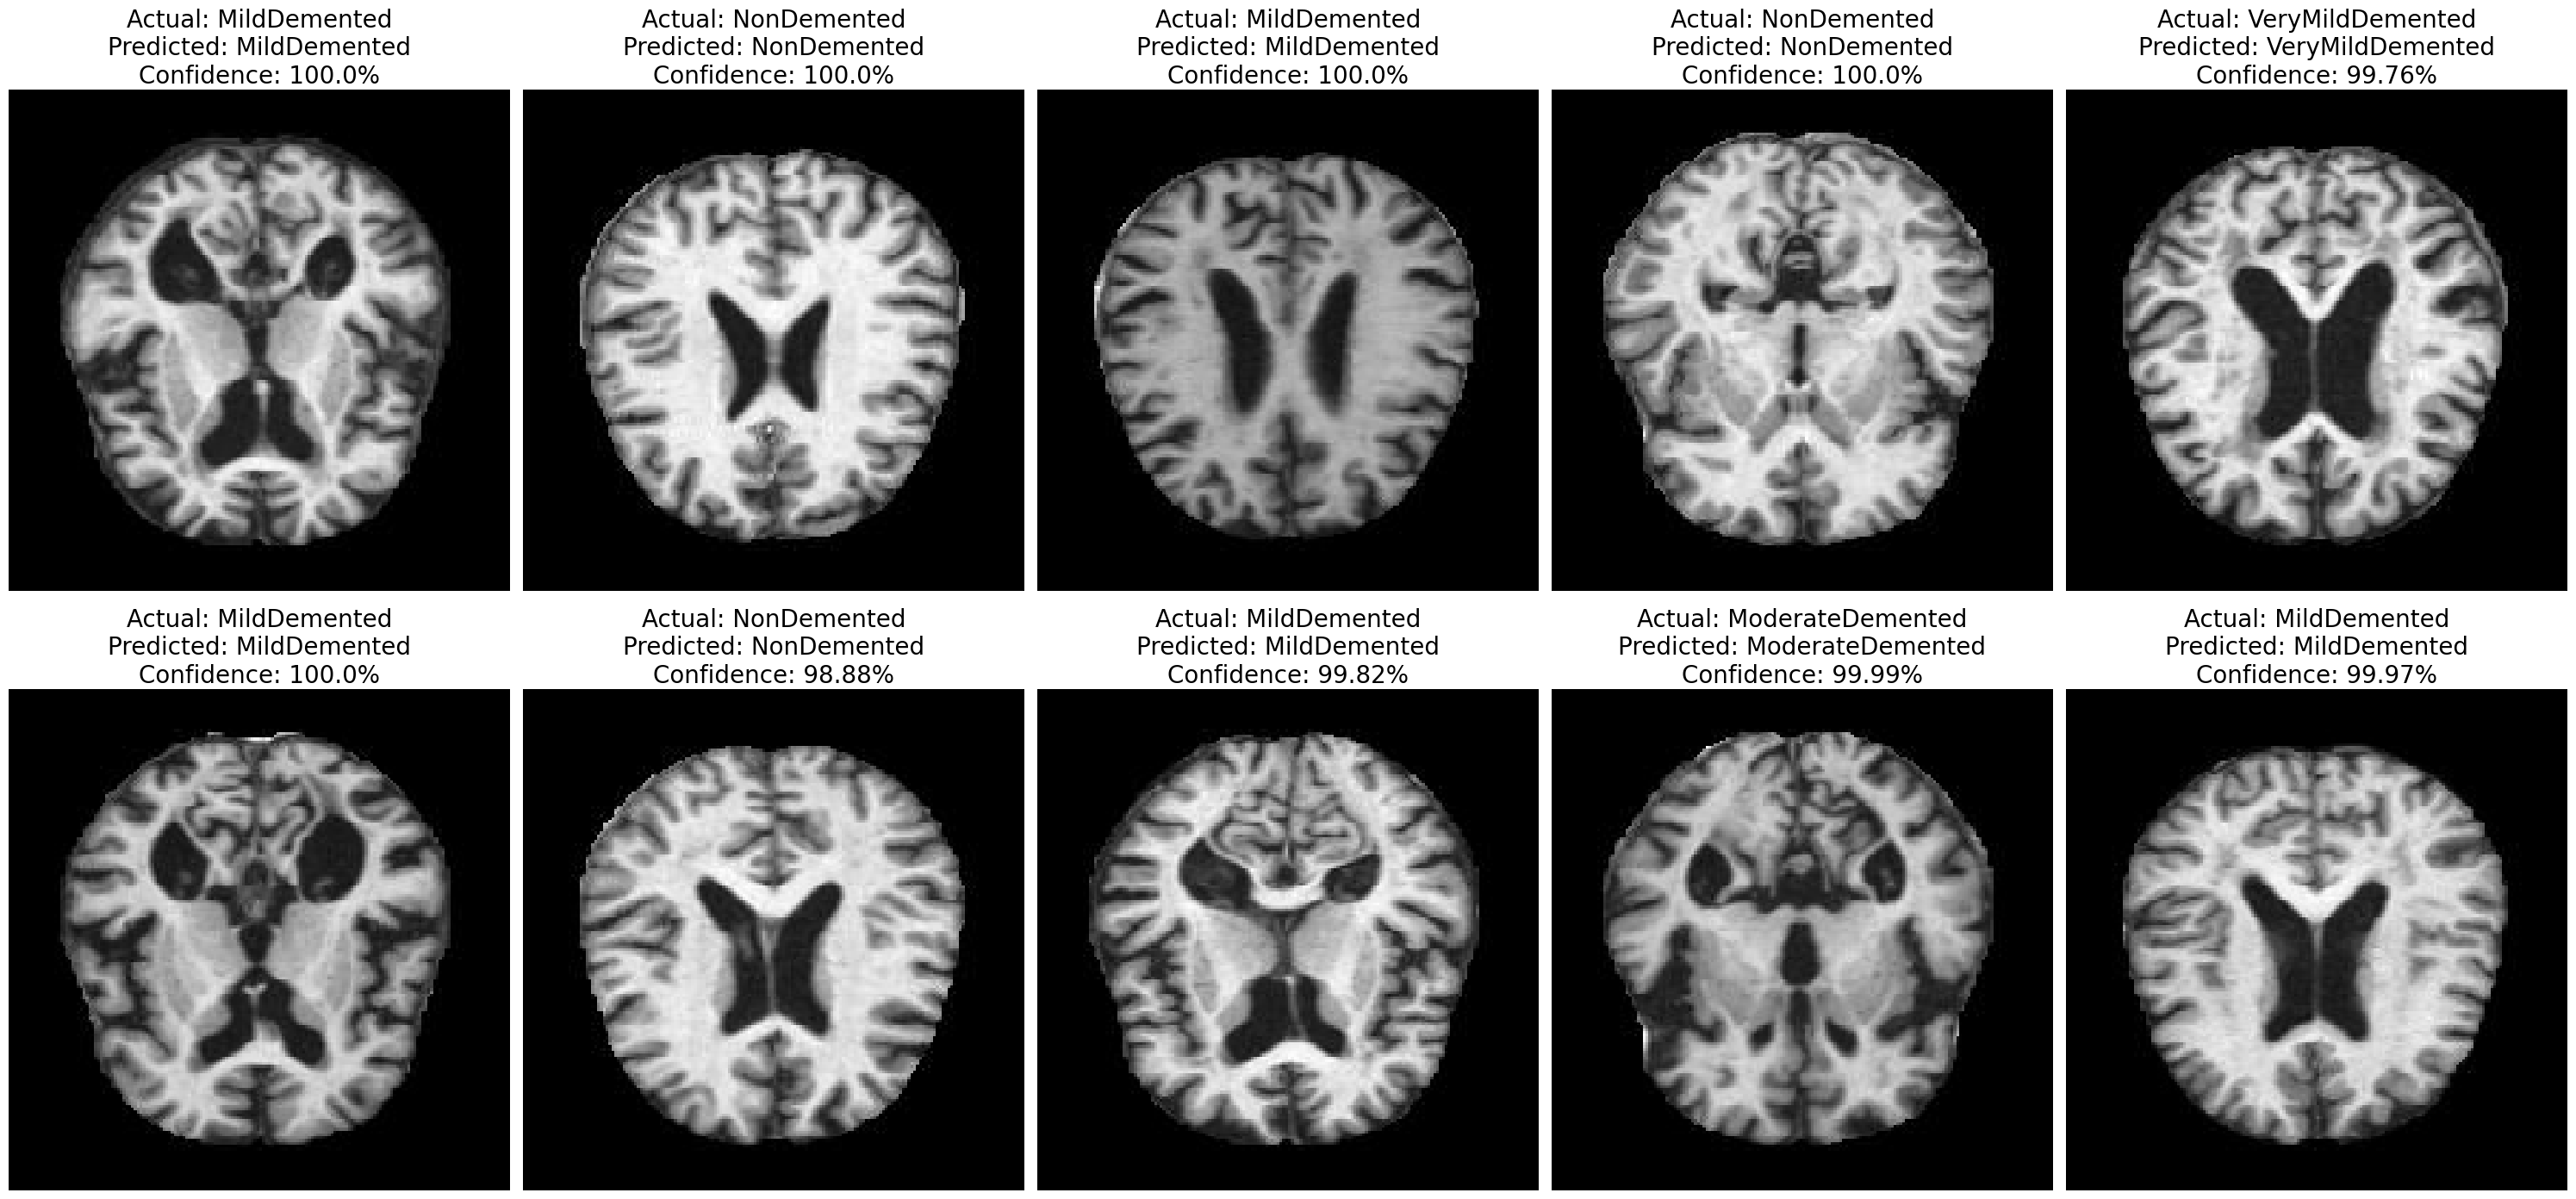

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test set
predictions = model.predict(X_test)

# Convert predictions and true labels to label indices
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Define class names (replace with actual class names)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plotting the images with their actual and predicted labels
plt.figure(figsize=(30, 70))
for n, i in enumerate(np.random.randint(0, len(X_test), 10)):
    plt.subplot(10, 5, n + 1)
    plt.imshow(X_test[i])
    plt.axis('off')
    actual_label = class_names[y_true_classes[i]]
    predicted_label = class_names[y_pred_classes[i]]
    confidence = round(predictions[i][y_pred_classes[i]] * 100, 2)  # Confidence in percentage
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence}%", fontsize=20)

plt.tight_layout()
plt.show()
